Markdown用法

<mark><font color=red size=4 face=雅黑>叠加字体的变化<font><mark>

<mark>黄色高亮<mark>

<font color=steel size=5 face=雅黑>5号雅黑</font>

***<font color=green>绿色+加粗+斜体</font>**

## 一、读取数据

In [20]:
# 导入必要的库
import pandas as pd  # 用于数据处理和分析
import numpy as np   # 用于数值计算
import matplotlib.pyplot as plt  # 用于数据可视化
import mplfinance as mpf  # 用于绘制金融图表
from important_point_algorithm import rw_top, rw_bottom, rw_extremes,directional_change, get_extremes, find_pips # 导入重要点算法函数
from flag_pattern_algorithm_0328 import find_flags_pennants_pips, find_flags_pennants_trendline, plot_flag # 导入旗形和三角旗识别函数
# from get_stock_data import get_stock_data # 导入获取股票数据函数
import plotly.graph_objects as go

# data = get_stock_data("000001.SH", "1995-01-01", "2025-02-28")
# 从Excel文件中读取上证指数数据
data = pd.read_excel('上证指数数据.xlsx')
data = data.set_index('Date')  # 将Date列设置为索引

# 对价格取对数
# 对除Change列外的所有列取对数
# 将日期索引转换为DatetimeIndex格式
data.index = pd.to_datetime(data.index).copy()

# 对价格数据取对数
data.loc[:, data.columns != 'Change'] = np.log(data.loc[:, data.columns != 'Change']).copy()

# 提取收盘价数据
dat_slice = data['Close'].to_numpy().copy()

<font color=steel size=5 face=雅黑>1.单独绘制旗形&order=10</font>


=== 牛市旗形形态统计 ===
共发现牛市旗形数量: 36


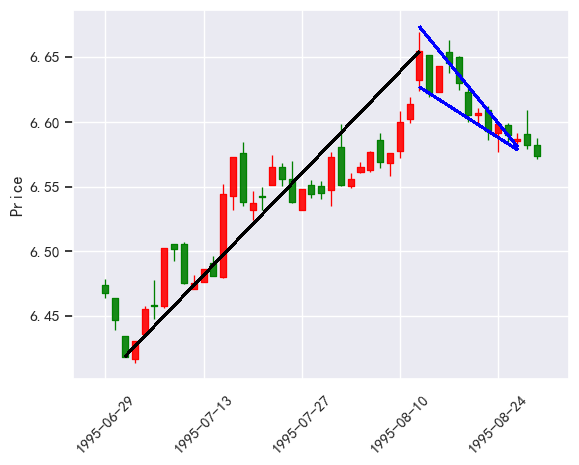

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 30
  旗形宽度/旗杆宽度: 0.3333333333333333
  旗形高度(flag_height): 0.06459607328992956
  旗杆高度(pole_height): 0.23566150124582652
  旗形高度/旗杆高度: 0.2741053288230868
  旗形斜率(slope): -0.0093


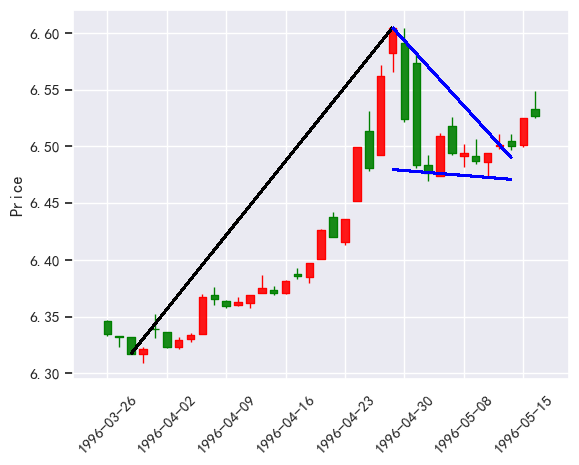

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 22
  旗形宽度/旗杆宽度: 0.45454545454545453
  旗形高度(flag_height): 0.1277496808502061
  旗杆高度(pole_height): 0.287546694001116
  旗形高度/旗杆高度: 0.4442745596292973
  旗形斜率(slope): -0.0115


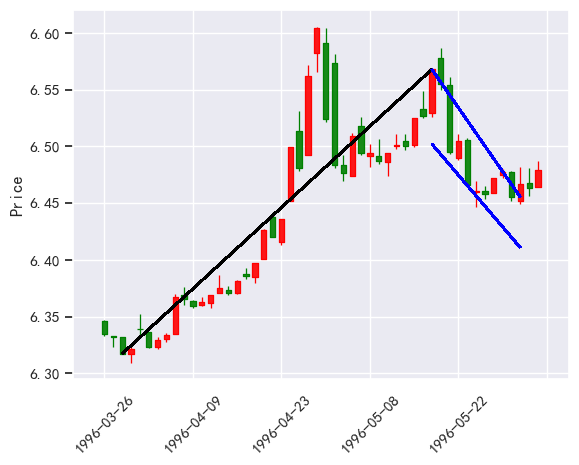

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 35
  旗形宽度/旗杆宽度: 0.2857142857142857
  旗形高度(flag_height): 0.11220886530454788
  旗杆高度(pole_height): 0.25074270566513857
  旗形高度/旗杆高度: 0.4475060002519091
  旗形斜率(slope): -0.0113


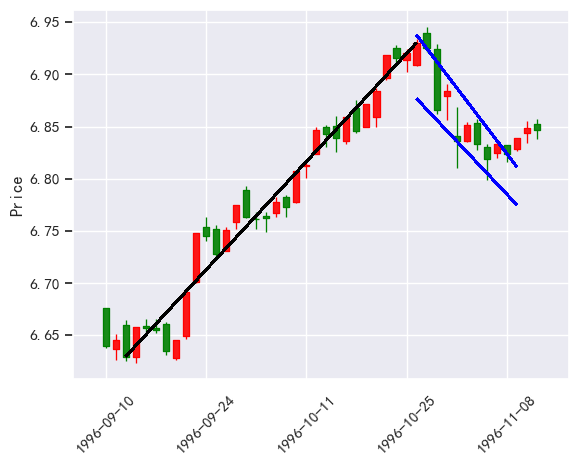

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 29
  旗形宽度/旗杆宽度: 0.3448275862068966
  旗形高度(flag_height): 0.11138201336037046
  旗杆高度(pole_height): 0.3008836406089319
  旗形高度/旗杆高度: 0.3701830153841339
  旗形斜率(slope): -0.0126


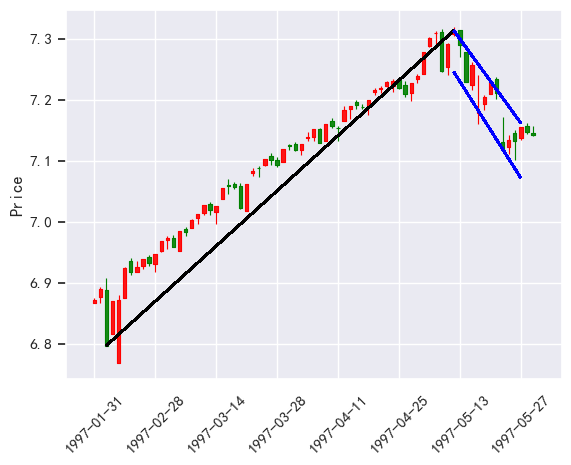

  旗形宽度(flag_width): 11
  旗杆宽度(pole_width): 57
  旗形宽度/旗杆宽度: 0.19298245614035087
  旗形高度(flag_height): 0.19447888566549754
  旗杆高度(pole_height): 0.5168329312883557
  旗形高度/旗杆高度: 0.37628965549989746
  旗形斜率(slope): -0.0138


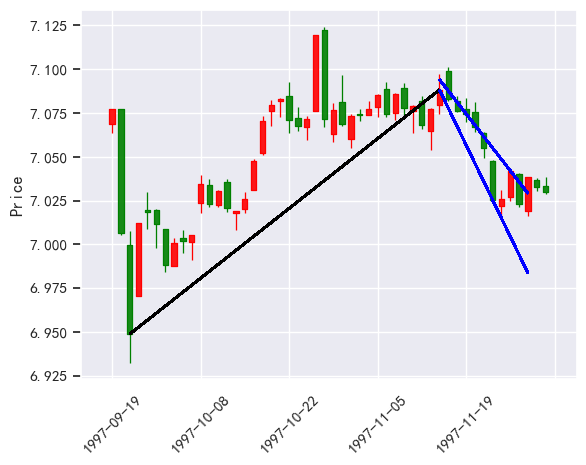

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 35
  旗形宽度/旗杆宽度: 0.2857142857142857
  旗形高度(flag_height): 0.0649406617064816
  旗杆高度(pole_height): 0.1394049026211146
  旗形高度/旗杆高度: 0.4658420219479823
  旗形斜率(slope): -0.0065


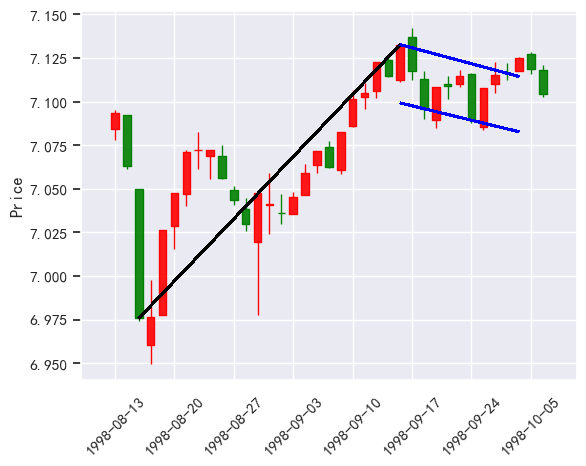

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 22
  旗形宽度/旗杆宽度: 0.45454545454545453
  旗形高度(flag_height): 0.04331373976487374
  旗杆高度(pole_height): 0.15681073759576858
  旗形高度/旗杆高度: 0.2762166700377955
  旗形斜率(slope): -0.0018


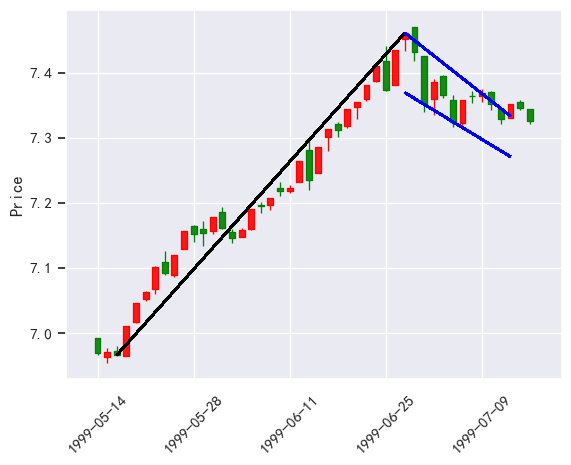

  旗形宽度(flag_width): 11
  旗杆宽度(pole_width): 30
  旗形宽度/旗杆宽度: 0.36666666666666664
  旗形高度(flag_height): 0.13652664927231495
  旗杆高度(pole_height): 0.4952780791315847
  旗形高度/旗杆高度: 0.27565655542781
  旗形斜率(slope): -0.0116


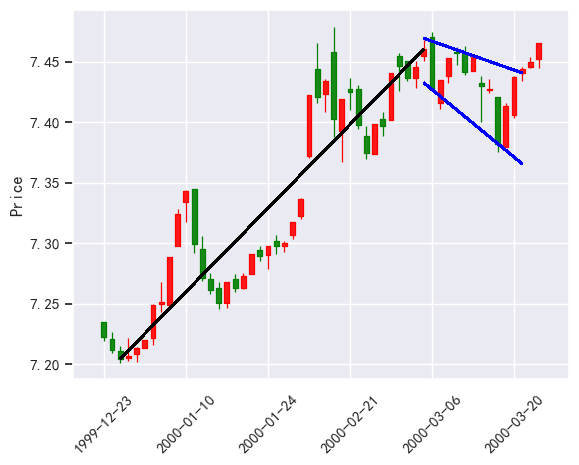

  旗形宽度(flag_width): 12
  旗杆宽度(pole_width): 37
  旗形宽度/旗杆宽度: 0.32432432432432434
  旗形高度(flag_height): 0.0780501363679802
  旗杆高度(pole_height): 0.2560914207731786
  旗形高度/旗杆高度: 0.3047745064334255
  旗形斜率(slope): -0.0024


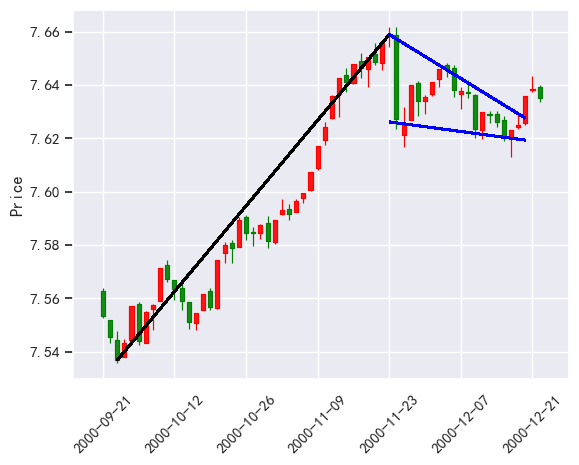

  旗形宽度(flag_width): 19
  旗杆宽度(pole_width): 38
  旗形宽度/旗杆宽度: 0.5
  旗形高度(flag_height): 0.03851343648213845
  旗杆高度(pole_height): 0.12205702292961185
  旗形高度/旗杆高度: 0.3155364235317166
  旗形斜率(slope): -0.0016


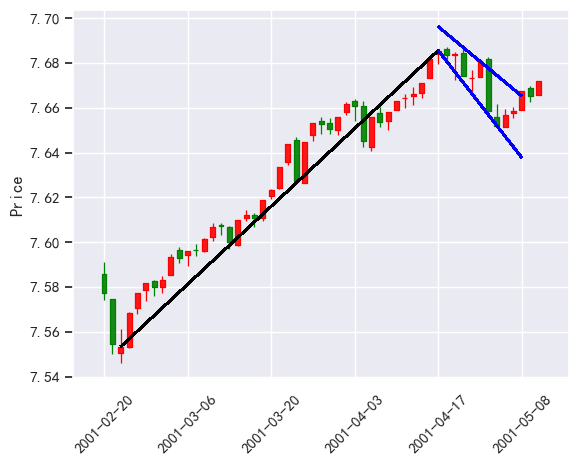

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 38
  旗形宽度/旗杆宽度: 0.2631578947368421
  旗形高度(flag_height): 0.0334582506544816
  旗杆高度(pole_height): 0.13213266363478926
  旗形高度/旗杆高度: 0.2532171057033953
  旗形斜率(slope): -0.0031


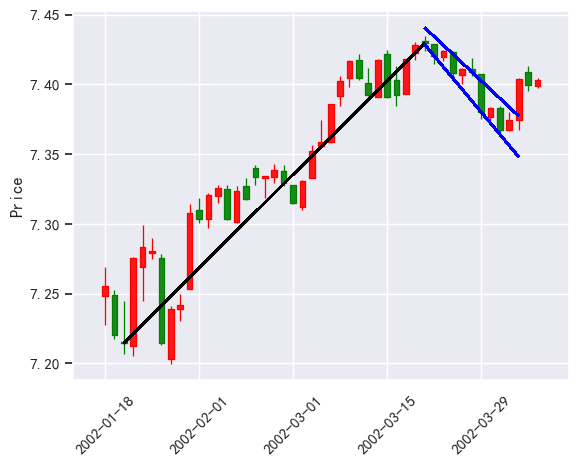

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 32
  旗形宽度/旗杆宽度: 0.3125
  旗形高度(flag_height): 0.06252778490373245
  旗杆高度(pole_height): 0.21525391652680348
  旗形高度/旗杆高度: 0.29048384304750374
  旗形斜率(slope): -0.0063


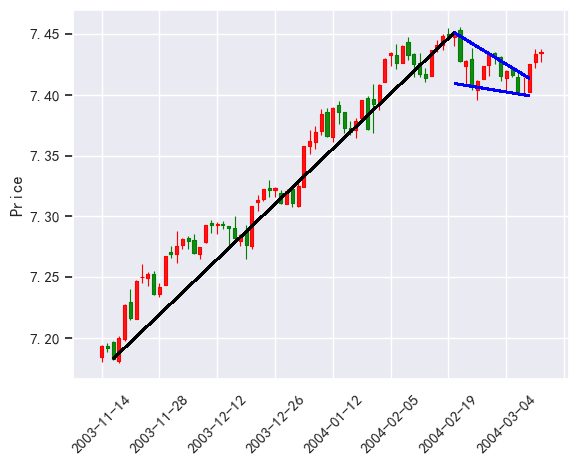

  旗形宽度(flag_width): 13
  旗杆宽度(pole_width): 59
  旗形宽度/旗杆宽度: 0.22033898305084745
  旗形高度(flag_height): 0.05041660400908654
  旗杆高度(pole_height): 0.2683185836365789
  旗形高度/旗杆高度: 0.18789829360970667
  旗形斜率(slope): -0.0029


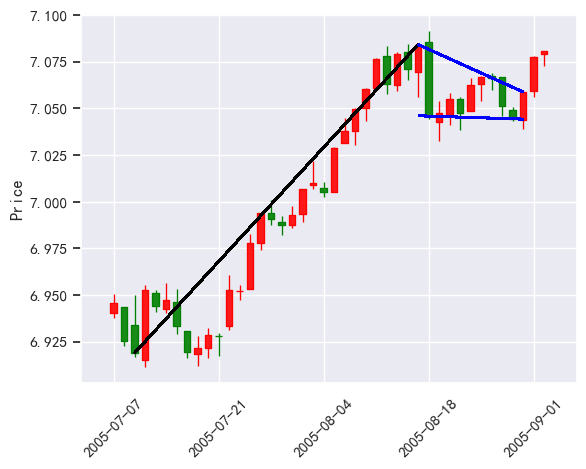

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 27
  旗形宽度/旗杆宽度: 0.37037037037037035
  旗形高度(flag_height): 0.03971847541365925
  旗杆高度(pole_height): 0.16489859942721274
  旗形高度/旗杆高度: 0.2408660567865601
  旗形斜率(slope): -0.0025


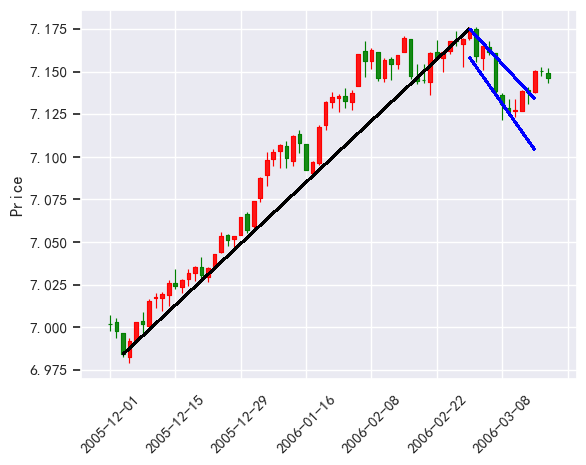

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 53
  旗形宽度/旗杆宽度: 0.18867924528301888
  旗形高度(flag_height): 0.04814877417281416
  旗杆高度(pole_height): 0.19120038246409
  旗形高度/旗杆高度: 0.25182362897133403
  旗形斜率(slope): -0.0041


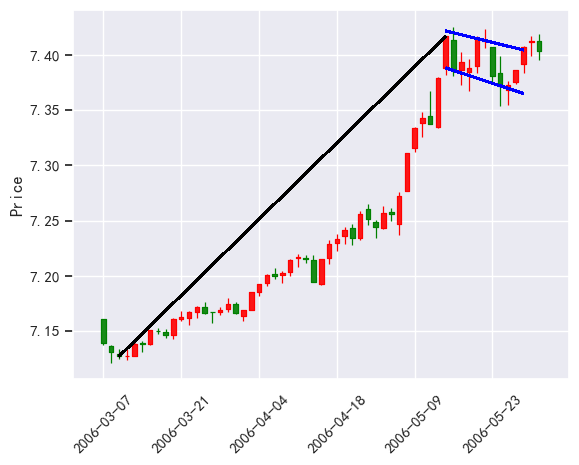

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 42
  旗形宽度/旗杆宽度: 0.23809523809523808
  旗形高度(flag_height): 0.04496224610030186
  旗杆高度(pole_height): 0.2900083712541548
  旗形高度/旗杆高度: 0.1550377525512816
  旗形斜率(slope): -0.0017


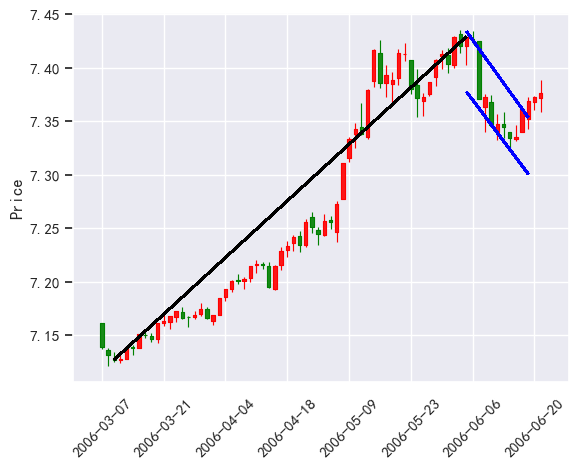

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 57
  旗形宽度/旗杆宽度: 0.17543859649122806
  旗形高度(flag_height): 0.09540771374219048
  旗杆高度(pole_height): 0.30227353914118726
  旗形高度/旗杆高度: 0.3156336939490659
  旗形斜率(slope): -0.0080


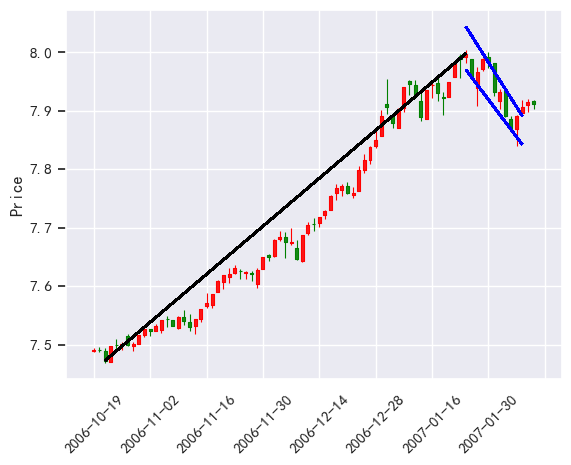

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 64
  旗形宽度/旗杆宽度: 0.15625
  旗形高度(flag_height): 0.1299656195319896
  旗杆高度(pole_height): 0.5253179678249289
  旗形高度/旗杆高度: 0.2474037202079919
  旗形斜率(slope): -0.0153


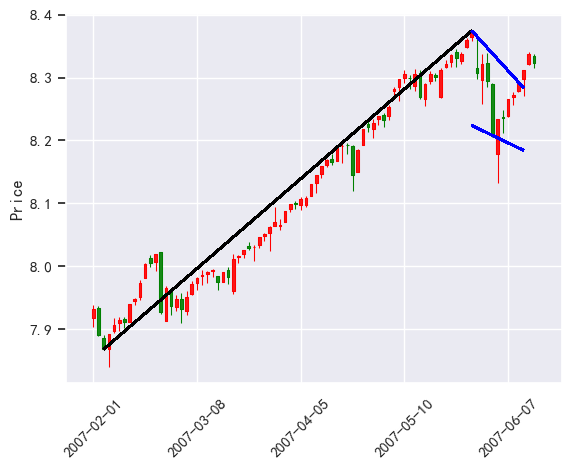

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 71
  旗形宽度/旗杆宽度: 0.14084507042253522
  旗形高度(flag_height): 0.16640315795750737
  旗杆高度(pole_height): 0.5063822984901876
  旗形高度/旗杆高度: 0.32861171974938586
  旗形斜率(slope): -0.0091


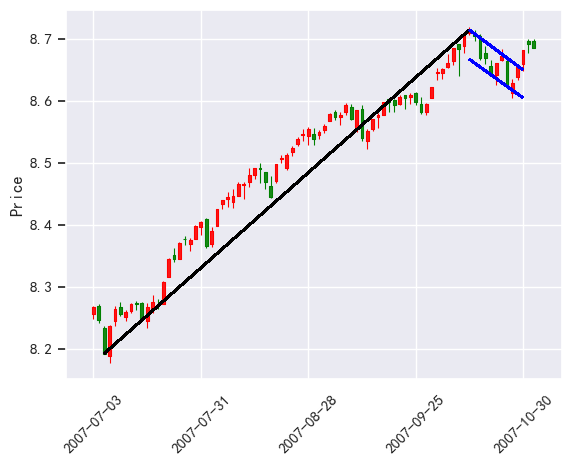

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 68
  旗形宽度/旗杆宽度: 0.14705882352941177
  旗形高度(flag_height): 0.09095720039128885
  旗杆高度(pole_height): 0.5216527478489912
  旗形高度/旗杆高度: 0.1743635028596059
  旗形斜率(slope): -0.0065


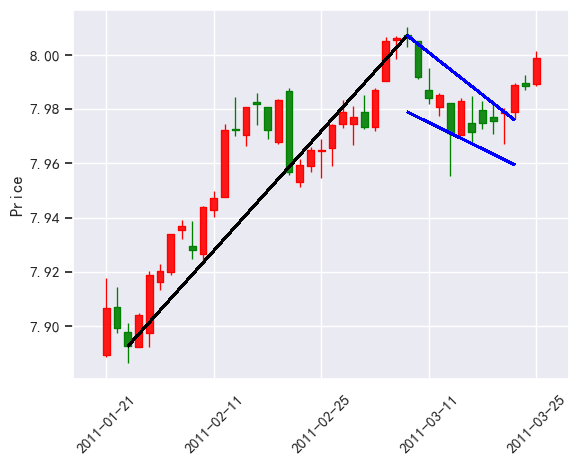

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 26
  旗形宽度/旗杆宽度: 0.38461538461538464
  旗形高度(flag_height): 0.03591116262275573
  旗杆高度(pole_height): 0.11447190483756131
  旗形高度/旗杆高度: 0.3137115842853723
  旗形斜率(slope): -0.0031


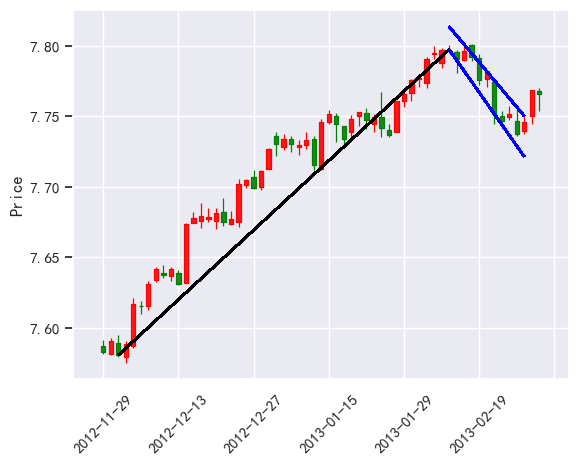

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 44
  旗形宽度/旗杆宽度: 0.22727272727272727
  旗形高度(flag_height): 0.05972224277602045
  旗杆高度(pole_height): 0.21690636044592182
  旗形高度/旗杆高度: 0.27533652149822574
  旗形斜率(slope): -0.0063


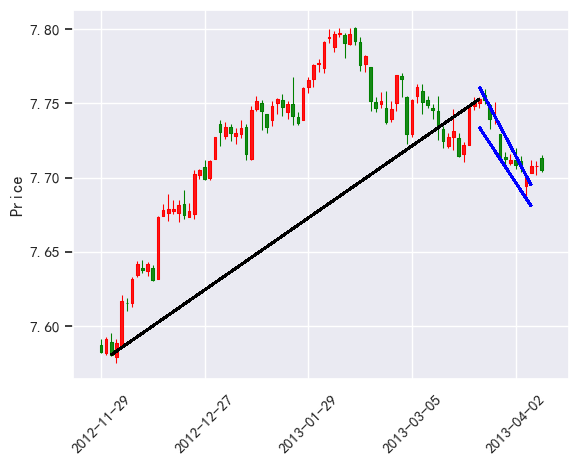

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 71
  旗形宽度/旗杆宽度: 0.14084507042253522
  旗形高度(flag_height): 0.05141632036280175
  旗杆高度(pole_height): 0.1723033499223421
  旗形高度/旗杆高度: 0.2984058080471176
  旗形斜率(slope): -0.0066


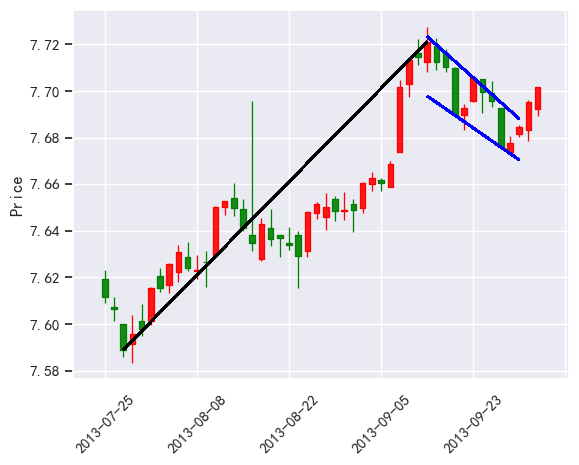

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 33
  旗形宽度/旗杆宽度: 0.30303030303030304
  旗形高度(flag_height): 0.045252170512543266
  旗杆高度(pole_height): 0.1321887840175604
  旗形高度/旗杆高度: 0.3423298795647581
  旗形斜率(slope): -0.0035


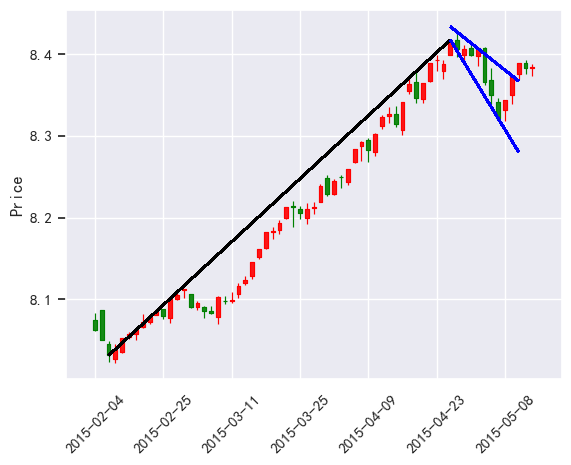

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 50
  旗形宽度/旗杆宽度: 0.2
  旗形高度(flag_height): 0.09618537017695772
  旗杆高度(pole_height): 0.3865471226610815
  旗形高度/旗杆高度: 0.2488321980378355
  旗形斜率(slope): -0.0067


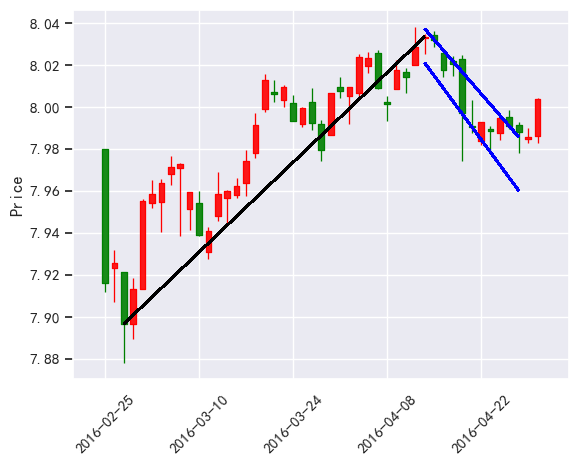

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 32
  旗形宽度/旗杆宽度: 0.3125
  旗形高度(flag_height): 0.04502046699523632
  旗杆高度(pole_height): 0.1369065760673731
  旗形高度/旗杆高度: 0.3288407926663895
  旗形斜率(slope): -0.0052


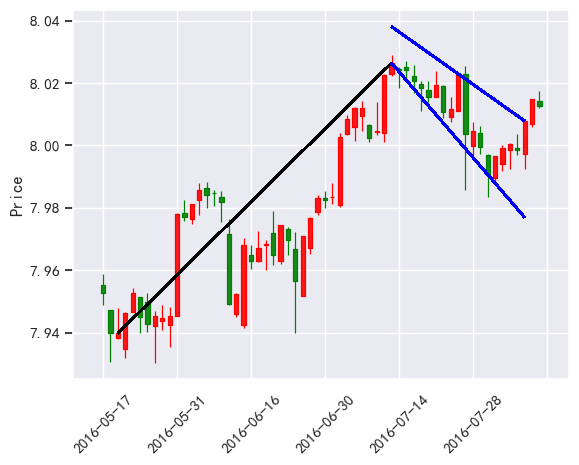

  旗形宽度(flag_width): 18
  旗杆宽度(pole_width): 37
  旗形宽度/旗杆宽度: 0.4864864864864865
  旗形高度(flag_height): 0.035688083864994447
  旗杆高度(pole_height): 0.08655724490778827
  旗形高度/旗杆高度: 0.41230614378974184
  旗形斜率(slope): -0.0017


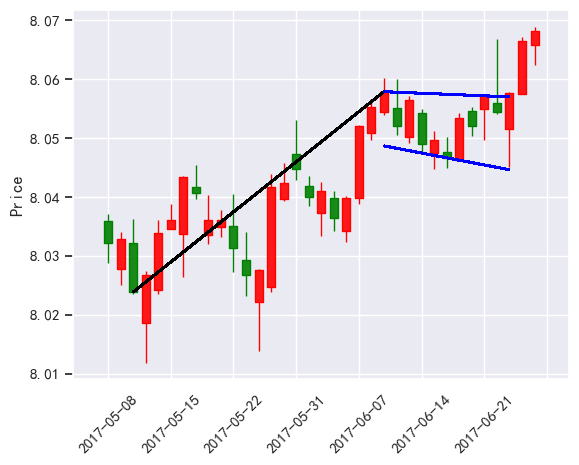

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 20
  旗形宽度/旗杆宽度: 0.5
  旗形高度(flag_height): 0.011218401958950963
  旗杆高度(pole_height): 0.034011408165673274
  旗形高度/旗杆高度: 0.3298423253840272
  旗形斜率(slope): -0.0001


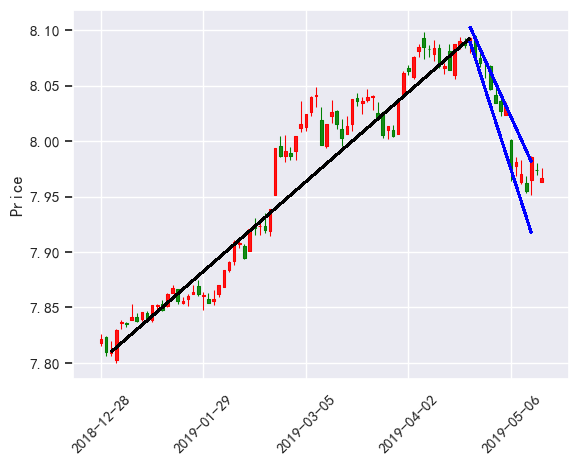

  旗形宽度(flag_width): 12
  旗杆宽度(pole_width): 70
  旗形宽度/旗杆宽度: 0.17142857142857143
  旗形高度(flag_height): 0.13738020793637773
  旗杆高度(pole_height): 0.2831005027269944
  旗形高度/旗杆高度: 0.48527009529495324
  旗形斜率(slope): -0.0102


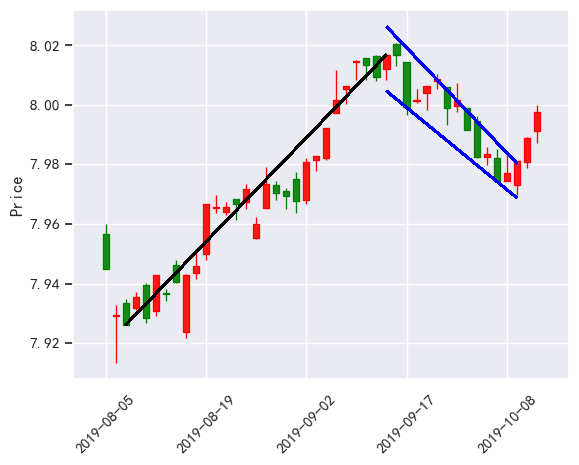

  旗形宽度(flag_width): 13
  旗杆宽度(pole_width): 26
  旗形宽度/旗杆宽度: 0.5
  旗形高度(flag_height): 0.042471642956810385
  旗杆高度(pole_height): 0.0905996684944812
  旗形高度/旗杆高度: 0.4687836463705991
  旗形斜率(slope): -0.0035


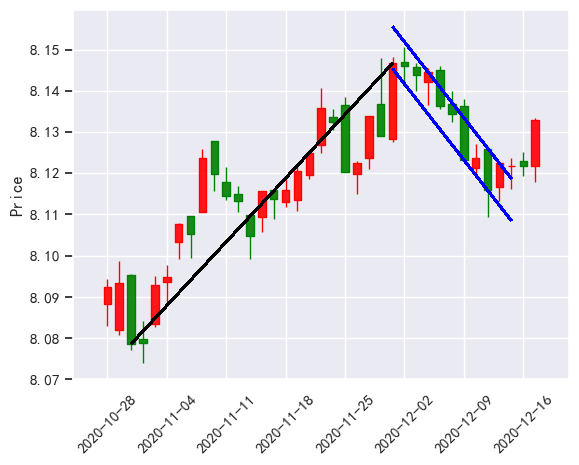

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 22
  旗形宽度/旗杆宽度: 0.45454545454545453
  旗形高度(flag_height): 0.030814441704002604
  旗杆高度(pole_height): 0.0681479498347386
  旗形高度/旗杆高度: 0.45216975387709846
  旗形斜率(slope): -0.0037


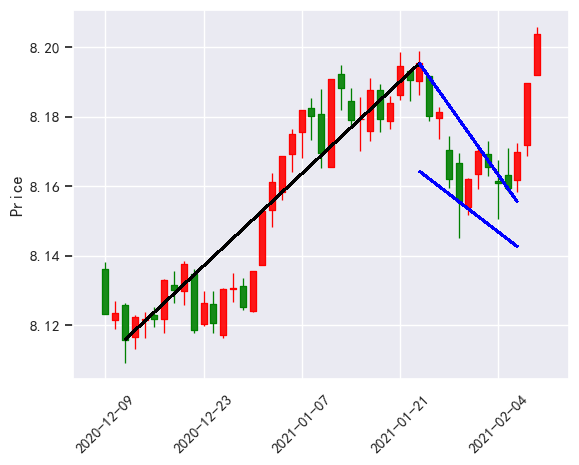

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 30
  旗形宽度/旗杆宽度: 0.3333333333333333
  旗形高度(flag_height): 0.039730227789082306
  旗杆高度(pole_height): 0.07952260027526137
  旗形高度/旗杆高度: 0.4996092639269739
  旗形斜率(slope): -0.0040


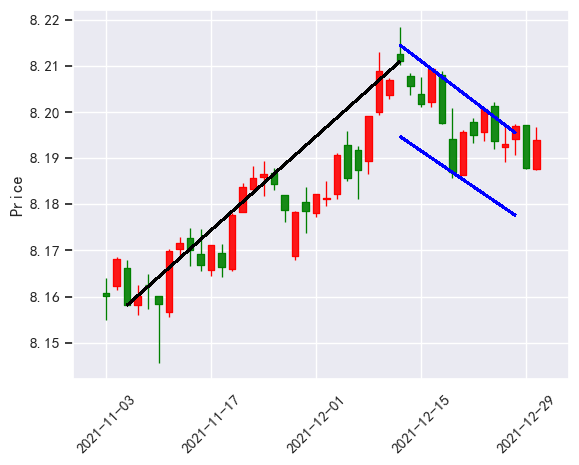

  旗形宽度(flag_width): 11
  旗杆宽度(pole_width): 26
  旗形宽度/旗杆宽度: 0.4230769230769231
  旗形高度(flag_height): 0.02405171642448245
  旗杆高度(pole_height): 0.052855897641064686
  旗形高度/旗杆高度: 0.4550431928677765
  旗形斜率(slope): -0.0017


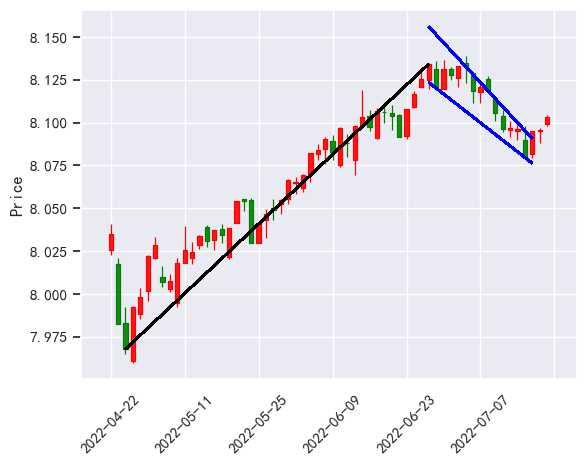

  旗形宽度(flag_width): 14
  旗杆宽度(pole_width): 41
  旗形宽度/旗杆宽度: 0.34146341463414637
  旗形高度(flag_height): 0.054599064497352856
  旗杆高度(pole_height): 0.16646172622673294
  旗形高度/旗杆高度: 0.32799770695027497
  旗形斜率(slope): -0.0047


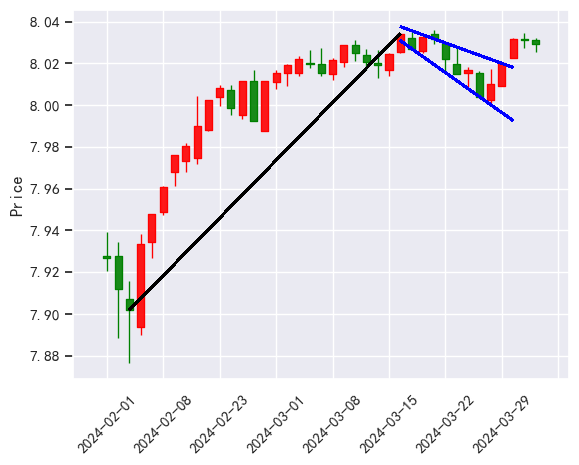

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 24
  旗形宽度/旗杆宽度: 0.4166666666666667
  旗形高度(flag_height): 0.0302051321970076
  旗杆高度(pole_height): 0.1324670298711741
  旗形高度/旗杆高度: 0.22802000034561418
  旗形斜率(slope): -0.0020


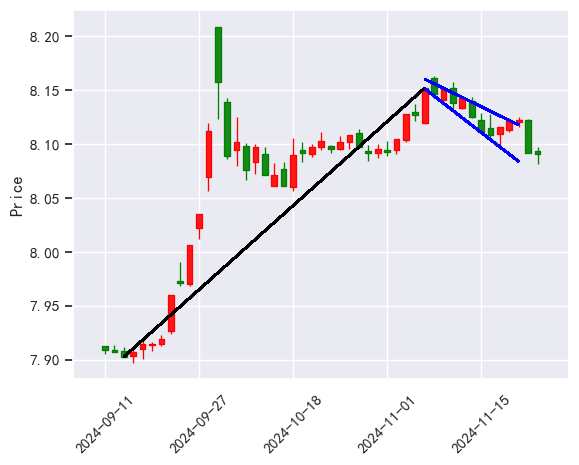

  旗形宽度(flag_width): 10
  旗杆宽度(pole_width): 32
  旗形宽度/旗杆宽度: 0.3125
  旗形高度(flag_height): 0.04322170849566831
  旗杆高度(pole_height): 0.24957974319205256
  旗形高度/旗杆高度: 0.1731779508339707
  旗形斜率(slope): -0.0043

=== 熊市旗形形态统计 ===
共发现熊市旗形数量: 34


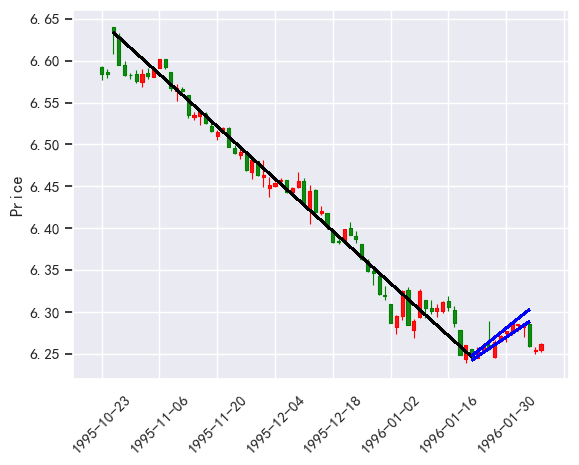

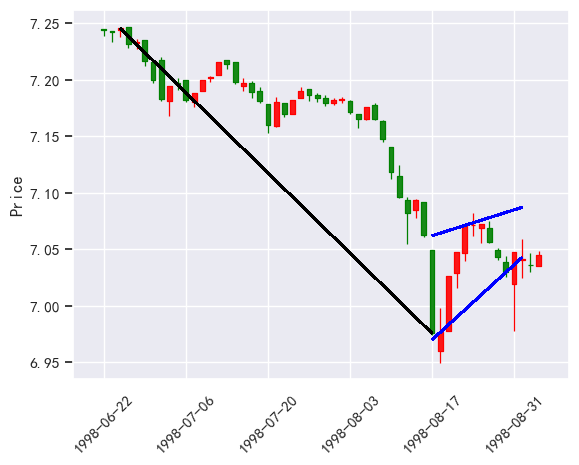

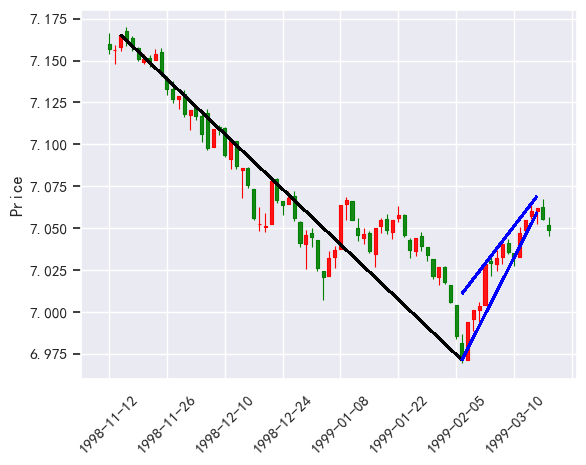

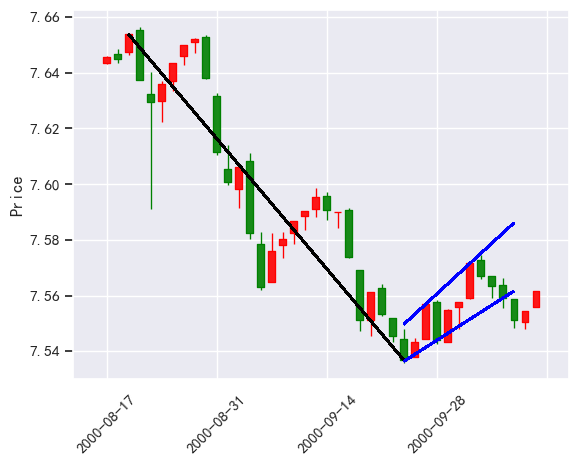

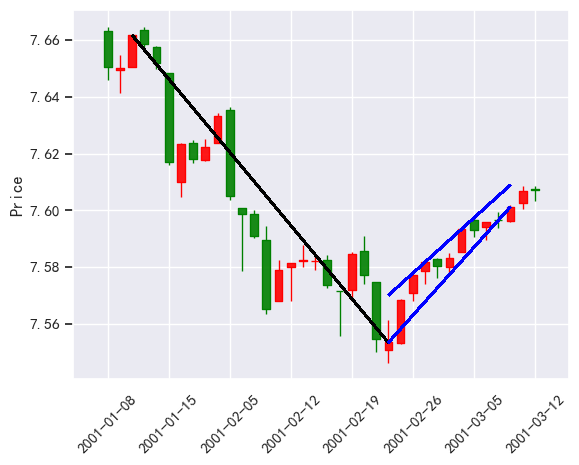

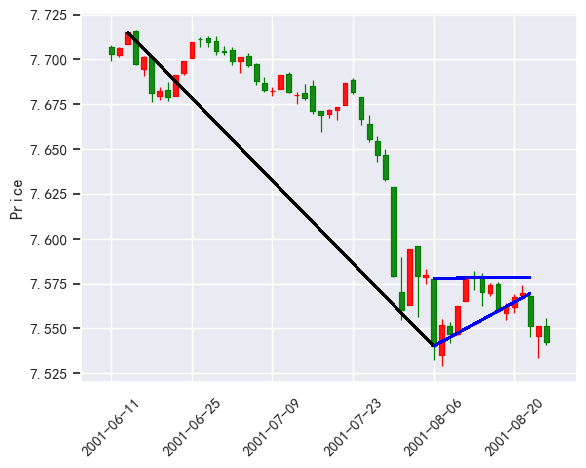

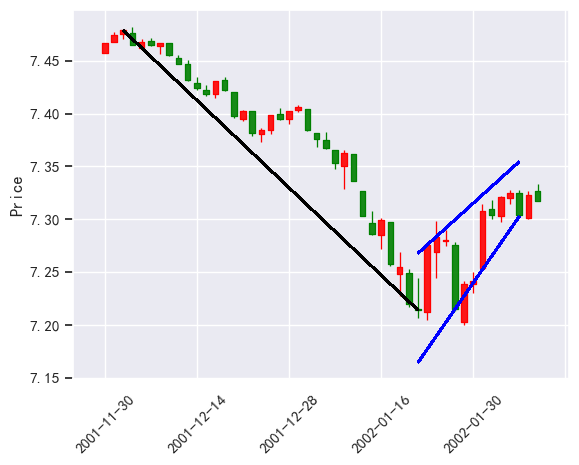

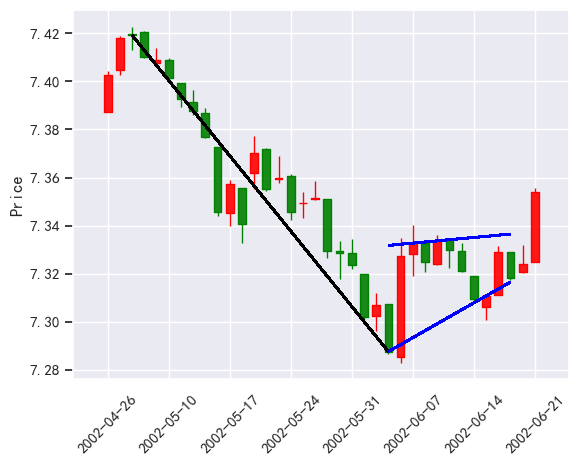

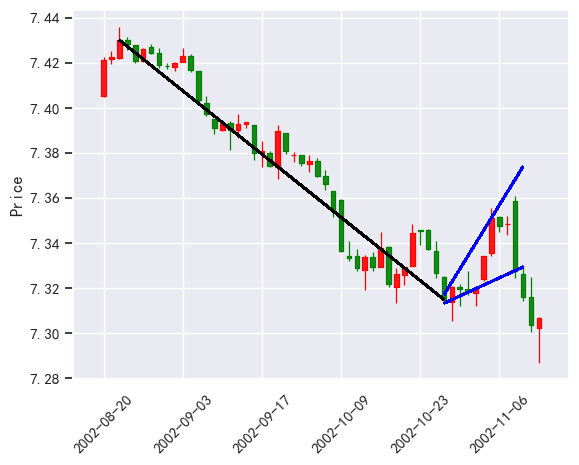

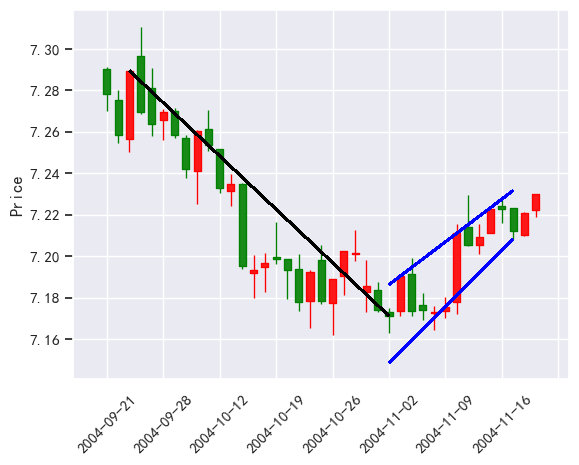

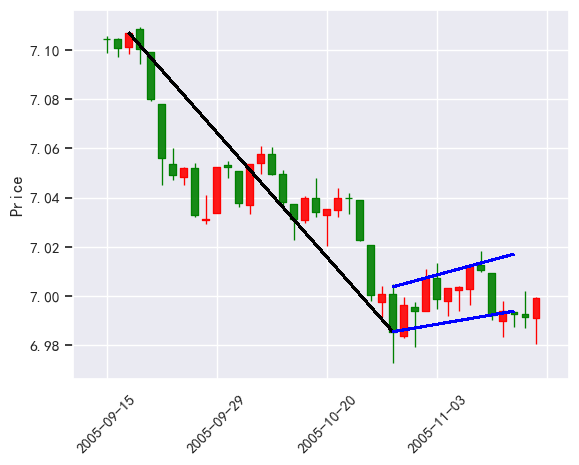

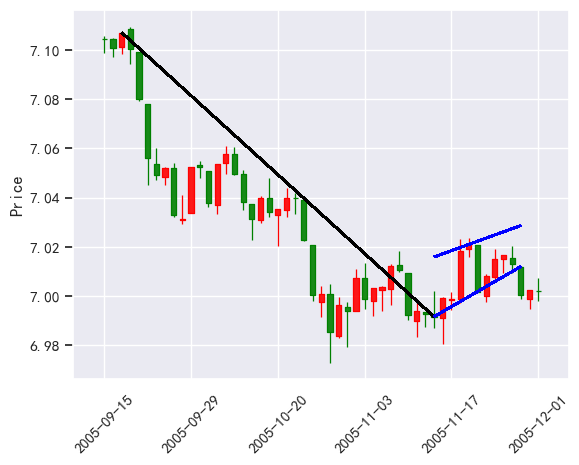

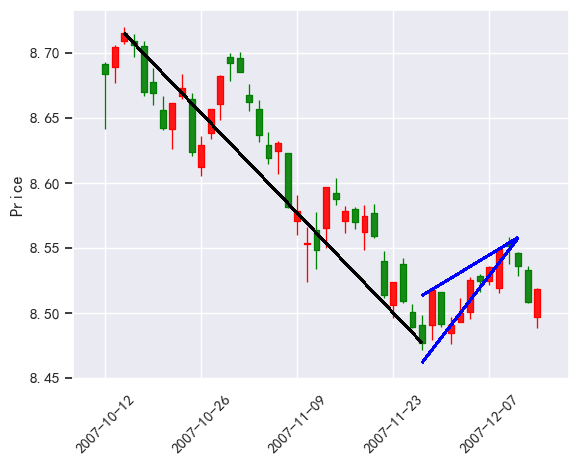

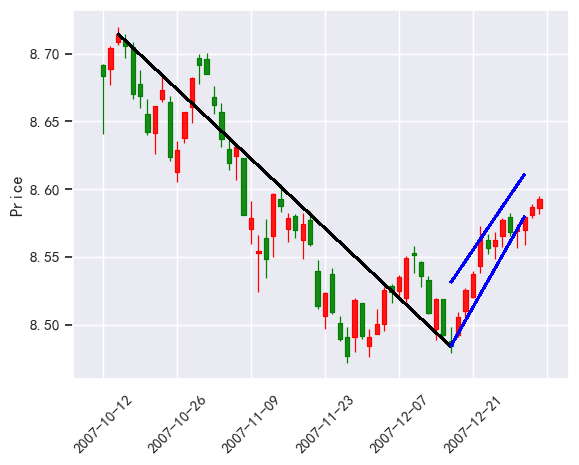

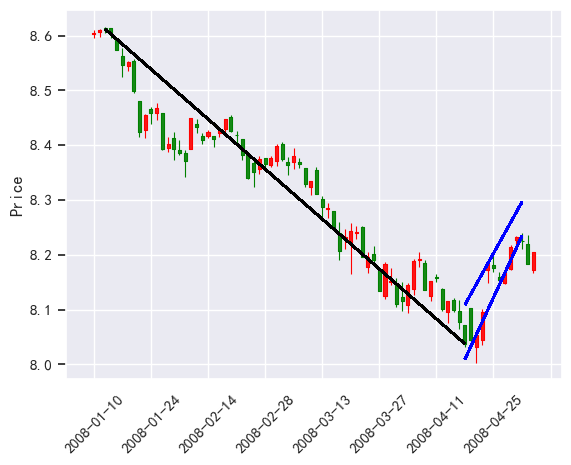

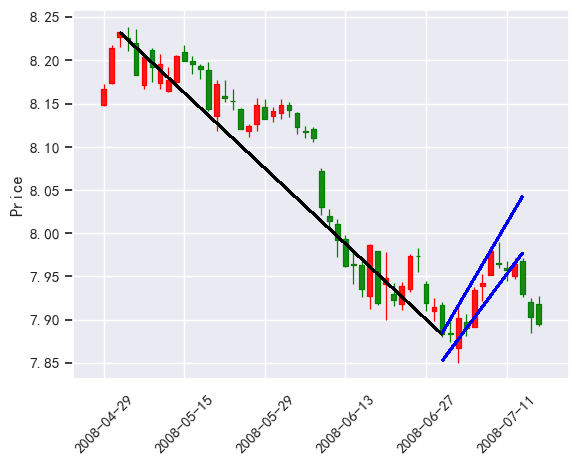

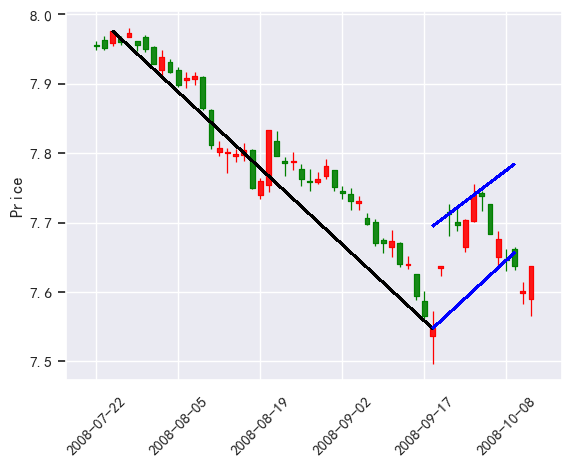

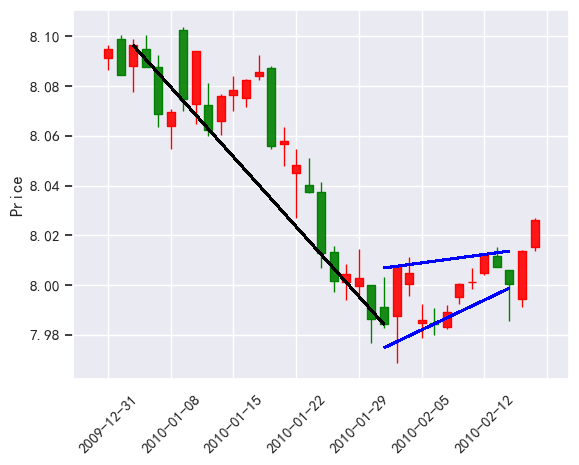

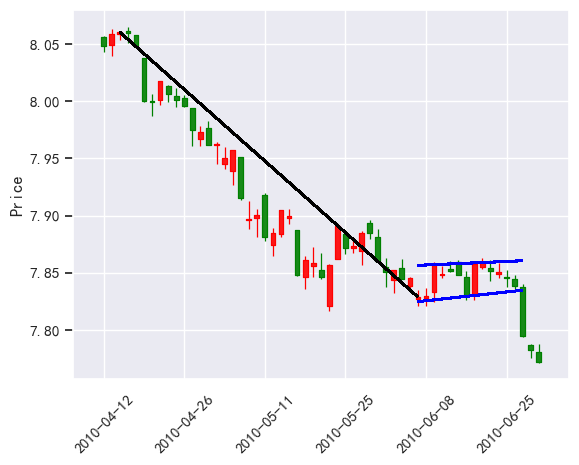

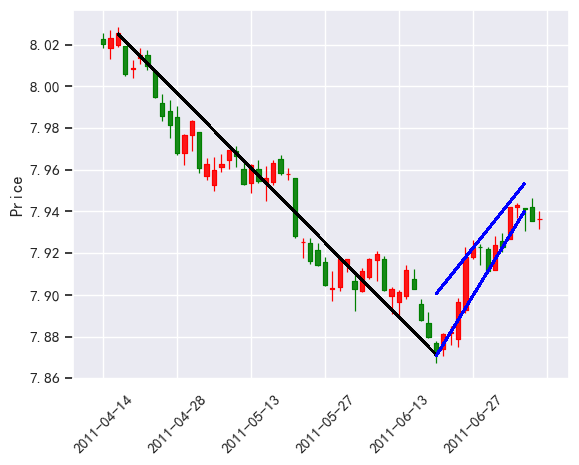

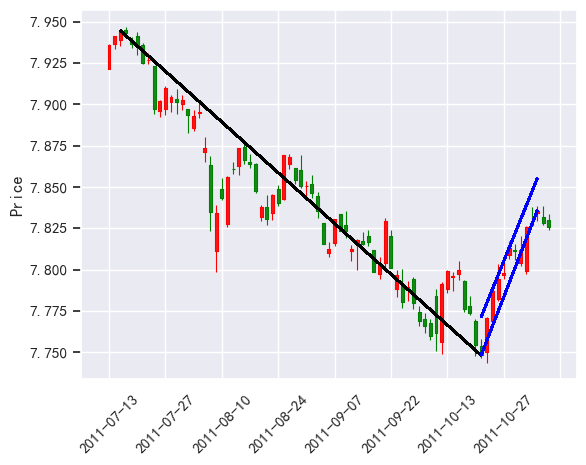

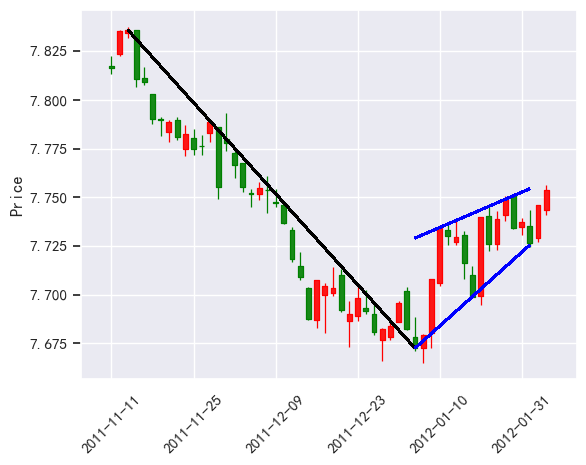

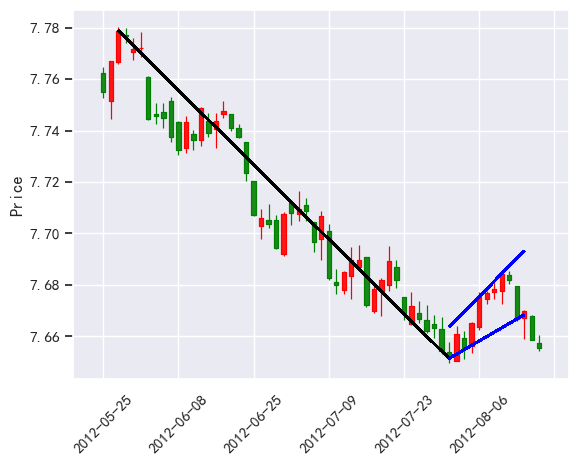

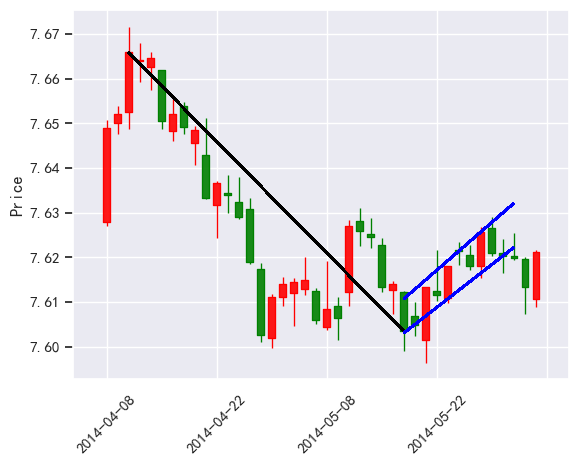

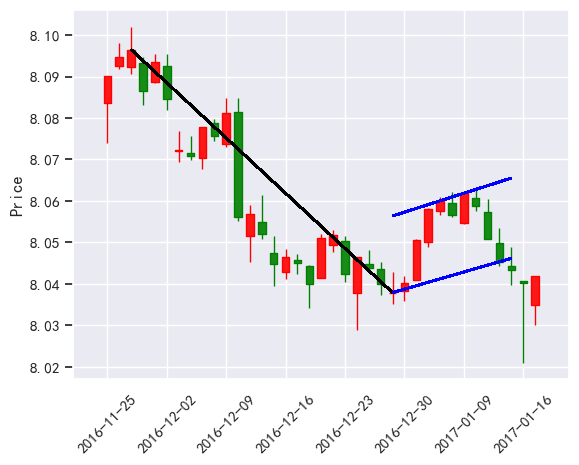

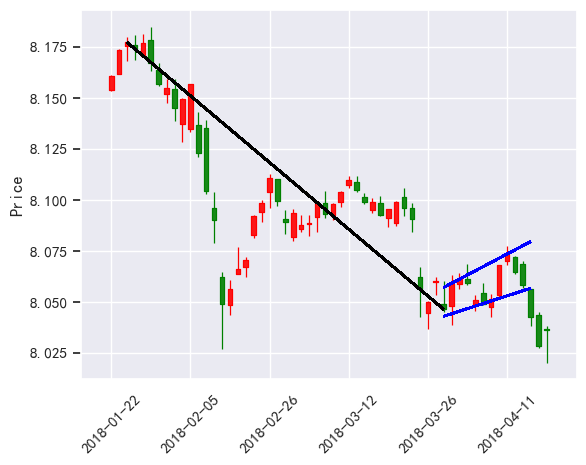

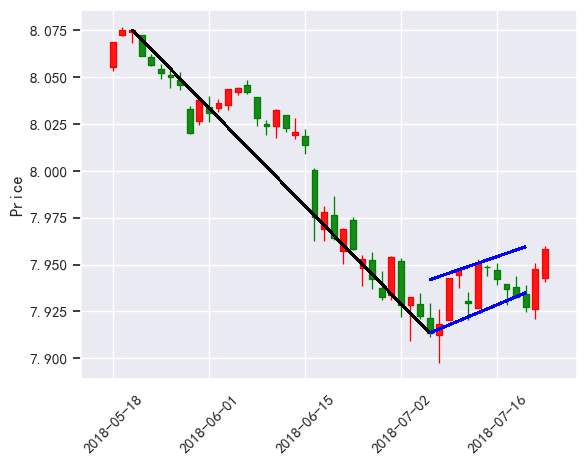

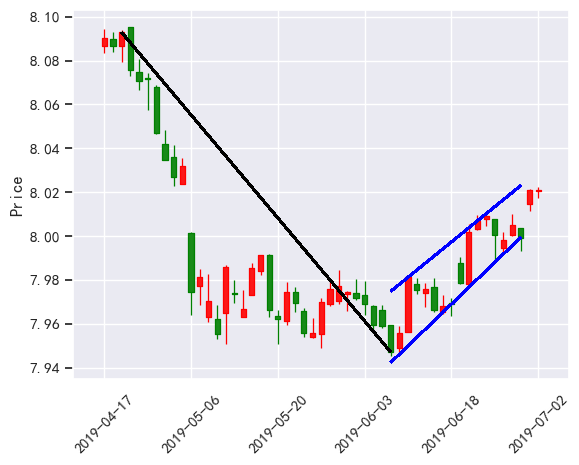

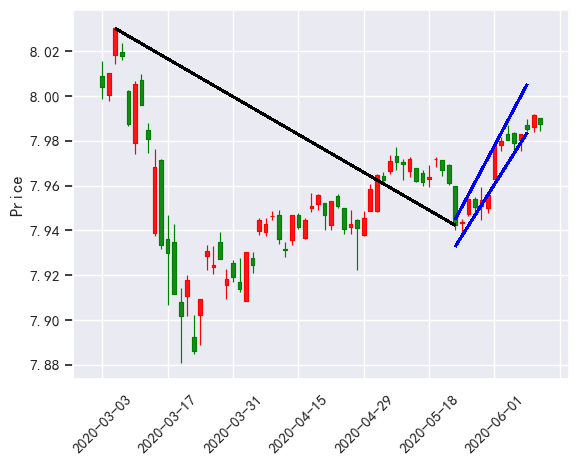

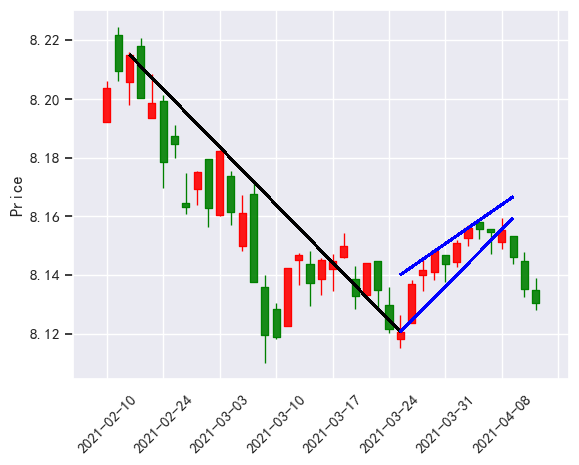

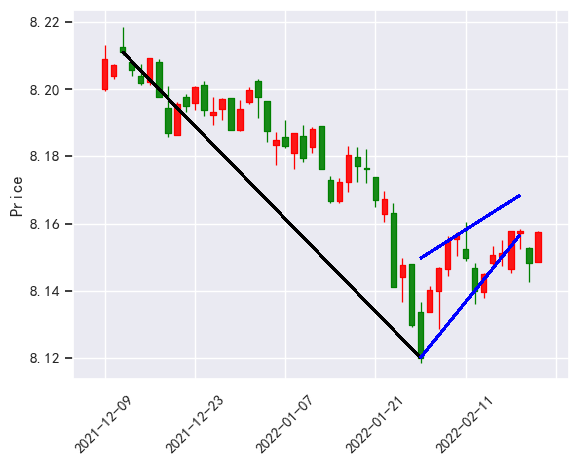

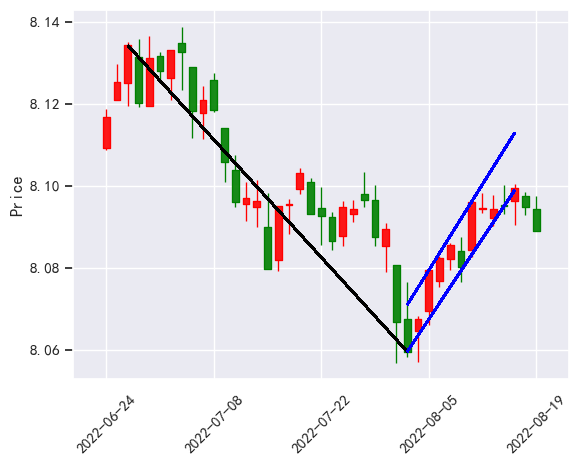

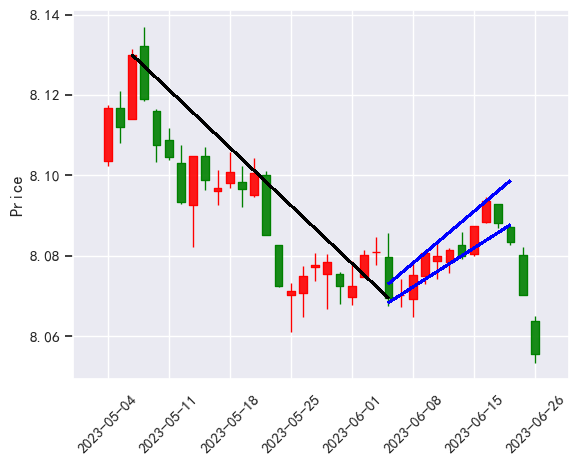

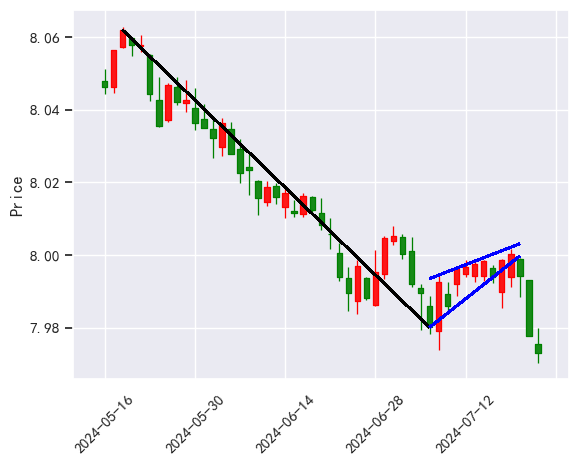


=== 牛市三角旗形态统计 ===
共发现牛市三角旗数量: 2


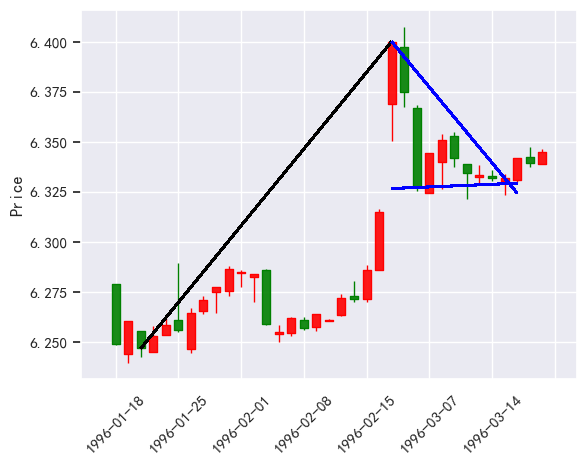

0    10.0
Name: pennant_width, dtype: float64


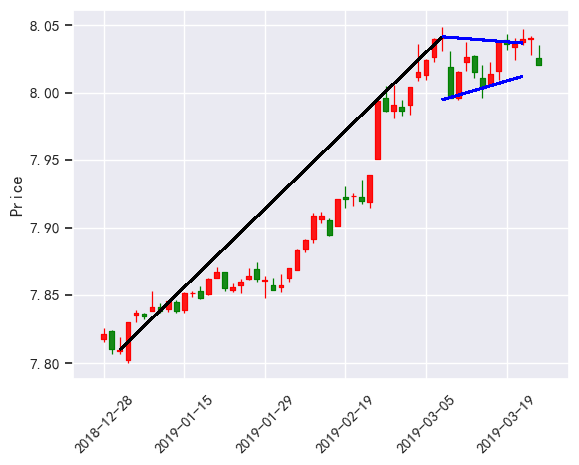

0    10.0
1    10.0
Name: pennant_width, dtype: float64

=== 熊市三角旗形态统计 ===
共发现熊市三角旗数量: 6


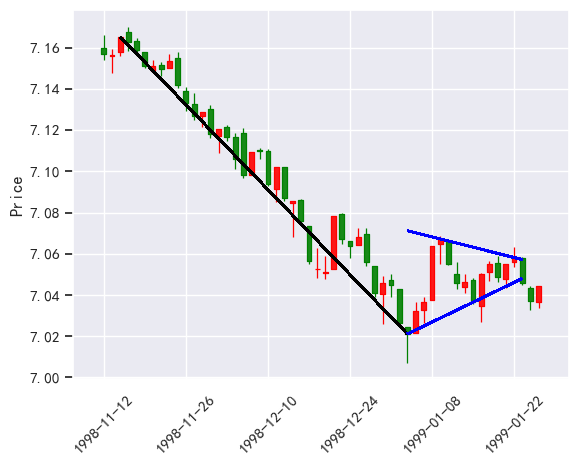

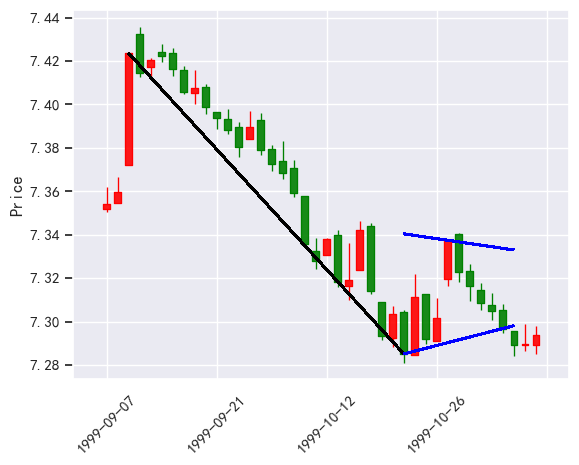

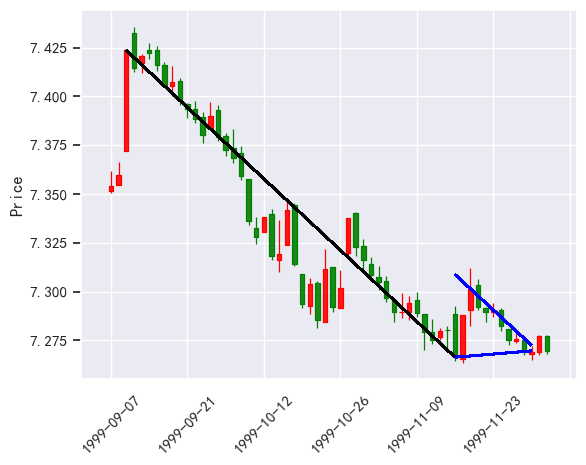

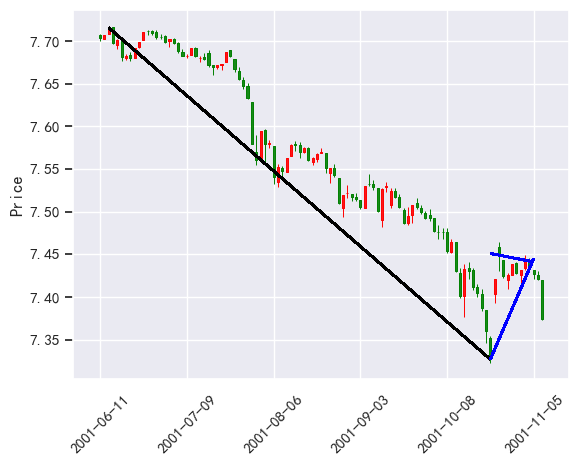

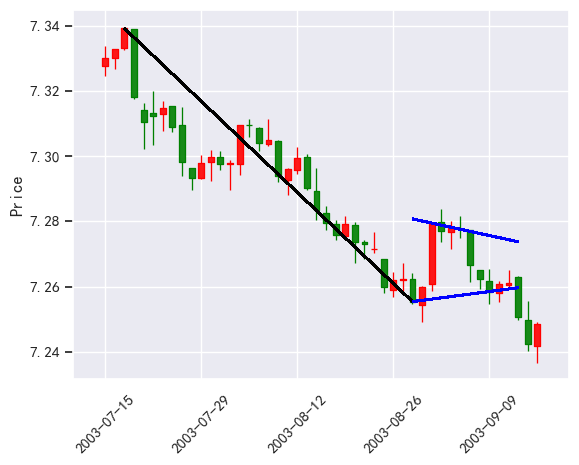

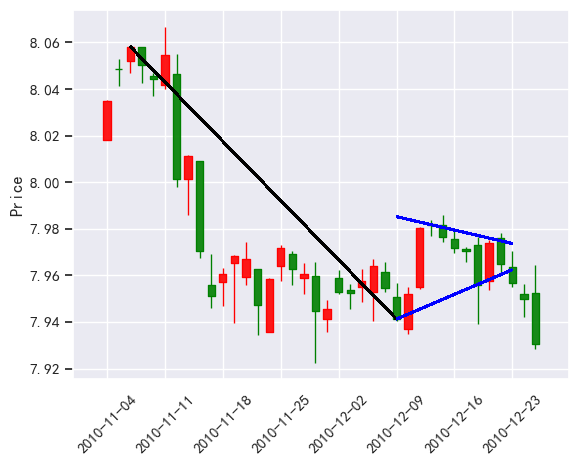

In [21]:
# 识别旗形和三角旗
# bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_pips(dat_slice, 12)  # 使用PIP点方法
bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_trendline(dat_slice, 10)  # 使用趋势线方法

# 创建数据框来存储形态属性
bull_flag_df = pd.DataFrame()
bull_pennant_df = pd.DataFrame()
bear_flag_df = pd.DataFrame()
bear_pennant_df = pd.DataFrame()

# 将形态数据组织到数据框中
hold_mult = 1.0  # 持有期乘数（持有时间 = 旗帜宽度 * 乘数）

# 打印牛市旗形形态统计信息
print("\n=== 牛市旗形形态统计 ===")
print(f"共发现牛市旗形数量: {len(bull_flags)}")
# 处理牛市旗形
for i, flag in enumerate(bull_flags):
    # 记录形态属性
    bull_flag_df.loc[i, 'flag_width'] = flag.flag_width
    bull_flag_df.loc[i, 'flag_height'] = flag.flag_height
    bull_flag_df.loc[i, 'pole_width'] = flag.pole_width
    bull_flag_df.loc[i, 'pole_height'] = flag.pole_height
    bull_flag_df.loc[i, 'slope'] = flag.resist_slope

    # 计算持有期收益
    hp = int(flag.flag_width * hold_mult)
    if flag.conf_x + hp >= len(data):
        bull_flag_df.loc[i, 'return'] = np.nan
    else:
        ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
        bull_flag_df.loc[i, 'return'] = ret

    # 绘制牛市旗形
    plot_flag(data, flag)
    # 打印当前旗形的属性
    print(f"  旗形宽度(flag_width): {flag.flag_width}")
    print(f"  旗杆宽度(pole_width): {flag.pole_width}")
    print(f"  旗形宽度/旗杆宽度: {flag.flag_width/flag.pole_width}")
    print(f"  旗形高度(flag_height): {flag.flag_height}")
    print(f"  旗杆高度(pole_height): {flag.pole_height}")
    print(f"  旗形高度/旗杆高度: {flag.flag_height/flag.pole_height}")
    print(f"  旗形斜率(slope): {flag.resist_slope:.4f}")



# if len(bull_flags) > 0:
#     print("\n旗形特征统计:")
#     print(f"旗形宽度均值: {bull_flag_df['flag_width'].mean():.2f}")
#     print(f"旗形高度均值: {bull_flag_df['flag_height'].mean():.2f}")
#     print(f"旗杆宽度均值: {bull_flag_df['pole_width'].mean():.2f}")
#     print(f"旗杆高度均值: {bull_flag_df['pole_height'].mean():.2f}")
#     print(f"旗形斜率均值: {bull_flag_df['slope'].mean():.4f}")
#     print(f"\n持有期收益均值: {bull_flag_df['return'].mean():.4f}")
#     print(f"持有期收益标准差: {bull_flag_df['return'].std():.4f}")



# 处理熊市旗形

# 打印熊市旗形形态统计信息
print("\n=== 熊市旗形形态统计 ===")
print(f"共发现熊市旗形数量: {len(bear_flags)}")

for i, flag in enumerate(bear_flags):
    # 记录形态属性
    bear_flag_df.loc[i, 'flag_width'] = flag.flag_width
    bear_flag_df.loc[i, 'flag_height'] = flag.flag_height
    bear_flag_df.loc[i, 'pole_width'] = flag.pole_width
    bear_flag_df.loc[i, 'pole_height'] = flag.pole_height
    bear_flag_df.loc[i, 'slope'] = flag.support_slope

    # 计算持有期收益（注意熊市形态是做空，所以收益取负）
    hp = int(flag.flag_width * hold_mult)
    if flag.conf_x + hp >= len(data):
        bear_flag_df.loc[i, 'return'] = np.nan
    else:
        ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
        bear_flag_df.loc[i, 'return'] = ret 

    # 绘制熊市旗形
    plot_flag(data, flag)


# if len(bear_flags) > 0:
#     print("\n旗形特征统计:")
#     print(f"旗形宽度均值: {bear_flag_df['flag_width'].mean():.2f}")
#     print(f"旗形高度均值: {bear_flag_df['flag_height'].mean():.2f}")
#     print(f"旗杆宽度均值: {bear_flag_df['pole_width'].mean():.2f}")
#     print(f"旗杆高度均值: {bear_flag_df['pole_height'].mean():.2f}")
#     print(f"旗形斜率均值: {bear_flag_df['slope'].mean():.4f}")
#     print(f"\n持有期收益均值: {bear_flag_df['return'].mean():.4f}")
#     print(f"持有期收益标准差: {bear_flag_df['return'].std():.4f}")

# 打印牛市三角旗形态统计信息
print("\n=== 牛市三角旗形态统计 ===")
print(f"共发现牛市三角旗数量: {len(bull_pennants)}")
# 处理牛市三角旗
for i, pennant in enumerate(bull_pennants):
    # 记录形态属性
    bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
    bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
    bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
    bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

    # 计算持有期收益
    hp = int(pennant.flag_width * hold_mult)
    if pennant.conf_x + hp >= len(data):
        bull_pennant_df.loc[i, 'return'] = np.nan
    else:
        ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
        bull_pennant_df.loc[i, 'return'] = ret 

    # 绘制牛市三角旗
    plot_flag(data, pennant)
    print(bull_pennant_df.pennant_width)


# if len(bull_pennants) > 0:
#     print("\n三角旗特征统计:")
#     print(f"三角旗宽度均值: {bull_pennant_df['pennant_width'].mean():.2f}")
#     print(f"三角旗高度均值: {bull_pennant_df['pennant_height'].mean():.2f}")
#     print(f"旗杆宽度均值: {bull_pennant_df['pole_width'].mean():.2f}")
#     print(f"旗杆高度均值: {bull_pennant_df['pole_height'].mean():.2f}")
#     print(f"\n持有期收益均值: {bull_pennant_df['return'].mean():.4f}")
#     print(f"持有期收益标准差: {bull_pennant_df['return'].std():.4f}")


# 打印熊市三角旗形态统计信息
print("\n=== 熊市三角旗形态统计 ===")
print(f"共发现熊市三角旗数量: {len(bear_pennants)}")
# 处理熊市三角旗
for i, pennant in enumerate(bear_pennants):
    # 记录形态属性
    bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
    bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
    bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
    bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

    # 计算持有期收益（注意熊市形态是做空，所以收益取负）
    hp = int(pennant.flag_width * hold_mult)
    if pennant.conf_x + hp >= len(data):
        bear_pennant_df.loc[i, 'return'] = np.nan
    else:
        ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
        bear_pennant_df.loc[i, 'return'] = ret 

    # 绘制熊市三角旗
    plot_flag(data, pennant)


# if len(bear_pennants) > 0:
#     print("\n三角旗特征统计:")
#     print(f"三角旗宽度均值: {bear_pennant_df['pennant_width'].mean():.2f}")
#     print(f"三角旗高度均值: {bear_pennant_df['pennant_height'].mean():.2f}")
#     print(f"旗杆宽度均值: {bear_pennant_df['pole_width'].mean():.2f}")
#     print(f"旗杆高度均值: {bear_pennant_df['pole_height'].mean():.2f}")
#     print(f"\n持有期收益均值: {bear_pennant_df['return'].mean():.4f}")
#     print(f"持有期收益标准差: {bear_pennant_df['return'].std():.4f}")


<font color=steel size=5 face=雅黑>2.不同order（5-50）</font>

In [18]:
# 定义要测试的窗口大小参数范围（从5到50）
orders = list(range(5, 51))

# 初始化结果存储列表
# 胜率（Win Rate）列表
bull_flag_wr = []  # 牛市旗形胜率
bull_pennant_wr = []  # 牛市三角旗胜率
bear_flag_wr = []  # 熊市旗形胜率
bear_pennant_wr = []  # 熊市三角旗胜率

# 平均收益列表
bull_flag_avg = []  # 牛市旗形平均收益
bull_pennant_avg = []  # 牛市三角旗平均收益
bear_flag_avg = []  # 熊市旗形平均收益
bear_pennant_avg = []  # 熊市三角旗平均收益

# 形态数量列表
bull_flag_count = []  # 牛市旗形数量
bull_pennant_count = []  # 牛市三角旗数量
bear_flag_count = []  # 熊市旗形数量
bear_pennant_count = []  # 熊市三角旗数量

# 总收益列表
bull_flag_total_ret = []  # 牛市旗形总收益
bull_pennant_total_ret = []  # 牛市三角旗总收益
bear_flag_total_ret = []  # 熊市旗形总收益
bear_pennant_total_ret = []  # 熊市三角旗总收益

# 创建一个字典来存储每个order参数下的形态详细信息
pattern_details = {}

# 遍历每个窗口大小参数进行测试
for order in orders:
    # 使用PIP点方法识别旗形和三角旗
    #bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_pips(dat_slice, order)
    # 也可以使用趋势线方法（取消下面的注释即可）
    bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_trendline(dat_slice, order)

    # 创建数据框来存储形态属性和收益
    bull_flag_df = pd.DataFrame()  # 牛市旗形数据框，用于存储牛市旗形形态的属性和收益数据，包含flag_width、flag_height、pole_width、pole_height、slope、start_x、end_x、conf_x、start_date、end_date、conf_date、return、exit_date等列
    bull_pennant_df = pd.DataFrame()  # 牛市三角旗数据框
    bear_flag_df = pd.DataFrame()  # 熊市旗形数据框
    bear_pennant_df = pd.DataFrame()  # 熊市三角旗数据框

    # 设置持有期乘数（持有时间 = 旗帜宽度 * 乘数）
    hold_mult = 1.0  # 默认持有时间等于旗帜宽度
    
    # 处理牛市旗形数据
    # 遍历所有识别出的牛市旗形形态
    # i是索引号(从0开始)，flag是每个旗形对象
    # enumerate是Python内置函数，用于同时获取列表中的索引和元素值
    for i, flag in enumerate(bull_flags):
        # 记录形态属性
        bull_flag_df.loc[i, 'flag_width'] = flag.flag_width  # 旗帜宽度
        bull_flag_df.loc[i, 'flag_height'] = flag.flag_height  # 旗帜高度
        bull_flag_df.loc[i, 'pole_width'] = flag.pole_width  # 旗杆宽度
        bull_flag_df.loc[i, 'pole_height'] = flag.pole_height  # 旗杆高度
        bull_flag_df.loc[i, 'slope'] = flag.resist_slope  # 阻力线斜率
        
        # 记录关键点位索引
        bull_flag_df.loc[i, 'start_x'] = flag.base_x  # 起始点索引
        bull_flag_df.loc[i, 'end_x'] = flag.tip_x  # 旗杆顶部索引
        bull_flag_df.loc[i, 'conf_x'] = flag.conf_x  # 确认点索引
        
        # 记录日期信息
        bull_flag_df.loc[i, 'start_date'] = data.index[flag.base_x]  # 起始日期
        bull_flag_df.loc[i, 'end_date'] = data.index[flag.tip_x]  # 旗杆顶部日期
        bull_flag_df.loc[i, 'conf_date'] = data.index[flag.conf_x]  # 确认日期

        # 计算持有期收益
        hp = int(flag.flag_width * hold_mult)  # 持有期长度
        if flag.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bull_flag_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bull_flag_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化）
            ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
            bull_flag_df.loc[i, 'return'] = ret 
            bull_flag_df.loc[i, 'exit_date'] = data.index[flag.conf_x + hp]  # 退出日期

    # 处理熊市旗形数据
    for i, flag in enumerate(bear_flags):
        # 记录形态属性
        bear_flag_df.loc[i, 'flag_width'] = flag.flag_width  # 旗帜宽度
        bear_flag_df.loc[i, 'flag_height'] = flag.flag_height  # 旗帜高度
        bear_flag_df.loc[i, 'pole_width'] = flag.pole_width  # 旗杆宽度
        bear_flag_df.loc[i, 'pole_height'] = flag.pole_height  # 旗杆高度
        bear_flag_df.loc[i, 'slope'] = flag.support_slope  # 支撑线斜率
        
        # 记录关键点位索引
        bear_flag_df.loc[i, 'start_x'] = flag.base_x  # 起始点索引
        bear_flag_df.loc[i, 'end_x'] = flag.tip_x  # 结束点索引
        bear_flag_df.loc[i, 'conf_x'] = flag.conf_x  # 确认点索引
        
        # 记录日期信息
        bear_flag_df.loc[i, 'start_date'] = data.index[flag.base_x]  # 起始日期
        bear_flag_df.loc[i, 'end_date'] = data.index[flag.tip_x]  # 旗杆顶部日期
        bear_flag_df.loc[i, 'conf_date'] = data.index[flag.conf_x]  # 确认日期

        # 计算持有期收益（注意熊市形态是做空，所以收益取负）
        hp = int(flag.flag_width * hold_mult)  # 持有期长度
        if flag.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bear_flag_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bear_flag_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化的负值）
            ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
            bear_flag_df.loc[i, 'return'] = ret 
            bear_flag_df.loc[i, 'exit_date'] = data.index[flag.conf_x + hp]  # 退出日期

    # 处理牛市三角旗数据
    for i, pennant in enumerate(bull_pennants):
        # 记录形态属性
        bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width  # 三角旗宽度
        bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height  # 三角旗高度
        bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width  # 旗杆宽度
        bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height  # 旗杆高度
        
        # 记录关键点位索引
        bull_pennant_df.loc[i, 'start_x'] = pennant.base_x  # 起始点索引
        bull_pennant_df.loc[i, 'end_x'] = pennant.tip_x  # 结束点索引
        bull_pennant_df.loc[i, 'conf_x'] = pennant.conf_x  # 确认点索引
        
        # 记录日期信息
        bull_pennant_df.loc[i, 'start_date'] = data.index[pennant.base_x]  # 起始日期
        bull_pennant_df.loc[i, 'end_date'] = data.index[pennant.tip_x]  # 旗杆顶部日期
        bull_pennant_df.loc[i, 'conf_date'] = data.index[pennant.conf_x]  # 确认日期

        # 计算持有期收益
        hp = int(pennant.flag_width * hold_mult)  # 持有期长度
        if pennant.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bull_pennant_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bull_pennant_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化）
            ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
            bull_pennant_df.loc[i, 'return'] = ret 
            bull_pennant_df.loc[i, 'exit_date'] = data.index[pennant.conf_x + hp]  # 退出日期

    # 处理熊市三角旗数据
    for i, pennant in enumerate(bear_pennants):
        # 记录形态属性
        bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width  # 三角旗宽度
        bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height  # 三角旗高度
        bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width  # 旗杆宽度
        bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height  # 旗杆高度
        
        # 记录关键点位索引
        bear_pennant_df.loc[i, 'start_x'] = pennant.base_x  # 起始点索引
        bear_pennant_df.loc[i, 'end_x'] = pennant.tip_x  # 结束点索引
        bear_pennant_df.loc[i, 'conf_x'] = pennant.conf_x  # 确认点索引
        
        # 记录日期信息
        bear_pennant_df.loc[i, 'start_date'] = data.index[pennant.base_x]  # 起始日期
        bear_pennant_df.loc[i, 'end_date'] = data.index[pennant.tip_x]  # 旗杆顶部日期
        bear_pennant_df.loc[i, 'conf_date'] = data.index[pennant.conf_x]  # 确认日期

        # 计算持有期收益（注意熊市形态是做空，所以收益取负）
        hp = int(pennant.flag_width * hold_mult)  # 持有期长度
        if pennant.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bear_pennant_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bear_pennant_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化的负值）
            ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
            bear_pennant_df.loc[i, 'return'] = ret 
            bear_pennant_df.loc[i, 'exit_date'] = data.index[pennant.conf_x + hp]  # 退出日期

    # 保存每个order参数下的形态详细信息
    # 将当前order参数下识别到的各类形态数据保存pattern_details字典到中
    # 如果某类形态的数据框不为空，则保存其副本；否则保存None
    #  pattern_details是一个嵌套字典
    # 外层键是order参数值（从orders = list(range(3, 49))可知是3到48的整数）
    # 内层是包含四个键的字典：'bull_flag'、'bear_flag'、'bull_pennant'和'bear_pennant'
    # 这四个键对应的值是DataFrame对象的副本（如果不为空）或None（如果为空）  
    #   
    pattern_details[order] = {
        'bull_flag': bull_flag_df.copy() if not bull_flag_df.empty else None,  # 保存牛市旗形数据
        'bear_flag': bear_flag_df.copy() if not bear_flag_df.empty else None,  # 保存熊市旗形数据
        'bull_pennant': bull_pennant_df.copy() if not bull_pennant_df.empty else None,  # 保存牛市三角旗数据
        'bear_pennant': bear_pennant_df.copy() if not bear_pennant_df.empty else None   # 保存熊市三角旗数据
    }

    # 计算牛市旗形的统计数据
    if len(bull_flag_df) > 0:  # 如果找到了牛市旗形
        bull_flag_count.append(len(bull_flag_df))  # 记录形态数量
        bull_flag_avg.append(bull_flag_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bull_flag_wr.append(len(bull_flag_df[bull_flag_df['return'] > 0]) / len(bull_flag_df))
        bull_flag_total_ret.append(bull_flag_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到牛市旗形
        bull_flag_count.append(0)  # 形态数量为0
        bull_flag_avg.append(np.nan)  # 平均收益为NaN
        bull_flag_wr.append(np.nan)  # 胜率为NaN
        bull_flag_total_ret.append(0)  # 总收益为0
    
    # 计算熊市旗形的统计数据
    if len(bear_flag_df) > 0:  # 如果找到了熊市旗形
        bear_flag_count.append(len(bear_flag_df))  # 记录形态数量
        bear_flag_avg.append(bear_flag_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bear_flag_wr.append(len(bear_flag_df[bear_flag_df['return'] > 0]) / len(bear_flag_df))
        bear_flag_total_ret.append(bear_flag_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到熊市旗形
        bear_flag_count.append(0)  # 形态数量为0
        bear_flag_avg.append(np.nan)  # 平均收益为NaN
        bear_flag_wr.append(np.nan)  # 胜率为NaN
        bear_flag_total_ret.append(0)  # 总收益为0
    
    # 计算牛市三角旗的统计数据
    if len(bull_pennant_df) > 0:  # 如果找到了牛市三角旗
        bull_pennant_count.append(len(bull_pennant_df))  # 记录形态数量
        bull_pennant_avg.append(bull_pennant_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bull_pennant_wr.append(len(bull_pennant_df[bull_pennant_df['return'] > 0]) / len(bull_pennant_df))
        bull_pennant_total_ret.append(bull_pennant_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到牛市三角旗
        bull_pennant_count.append(0)  # 形态数量为0
        bull_pennant_avg.append(np.nan)  # 平均收益为NaN
        bull_pennant_wr.append(np.nan)  # 胜率为NaN
        bull_pennant_total_ret.append(0)  # 总收益为0
    
    # 计算熊市三角旗的统计数据
    if len(bear_pennant_df) > 0:  # 如果找到了熊市三角旗
        bear_pennant_count.append(len(bear_pennant_df))  # 记录形态数量
        bear_pennant_avg.append(bear_pennant_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bear_pennant_wr.append(len(bear_pennant_df[bear_pennant_df['return'] > 0]) / len(bear_pennant_df))
        bear_pennant_total_ret.append(bear_pennant_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到熊市三角旗
        bear_pennant_count.append(0)  # 形态数量为0
        bear_pennant_avg.append(np.nan)  # 平均收益为NaN
        bear_pennant_wr.append(np.nan)  # 胜率为NaN
        bear_pennant_total_ret.append(0)  # 总收益为0
    
# 创建结果数据框，以窗口大小参数为索引
results_df = pd.DataFrame(index=orders)

# 添加牛市旗形的统计数据
results_df['bull_flag_count'] = bull_flag_count  # 形态数量
results_df['bull_flag_avg'] = bull_flag_avg  # 平均收益
results_df['bull_flag_wr'] = bull_flag_wr  # 胜率
results_df['bull_flag_total'] = bull_flag_total_ret  # 总收益

# 添加熊市旗形的统计数据
results_df['bear_flag_count'] = bear_flag_count  # 形态数量
results_df['bear_flag_avg'] = bear_flag_avg  # 平均收益
results_df['bear_flag_wr'] = bear_flag_wr  # 胜率
results_df['bear_flag_total'] = bear_flag_total_ret  # 总收益

# 添加牛市三角旗的统计数据
results_df['bull_pennant_count'] = bull_pennant_count  # 形态数量
results_df['bull_pennant_avg'] = bull_pennant_avg  # 平均收益
results_df['bull_pennant_wr'] = bull_pennant_wr  # 胜率
results_df['bull_pennant_total'] = bull_pennant_total_ret  # 总收益

# 添加熊市三角旗的统计数据
results_df['bear_pennant_count'] = bear_pennant_count  # 形态数量
results_df['bear_pennant_avg'] = bear_pennant_avg  # 平均收益
results_df['bear_pennant_wr'] = bear_pennant_wr  # 胜率
results_df['bear_pennant_total'] = bear_pennant_total_ret  # 总收益

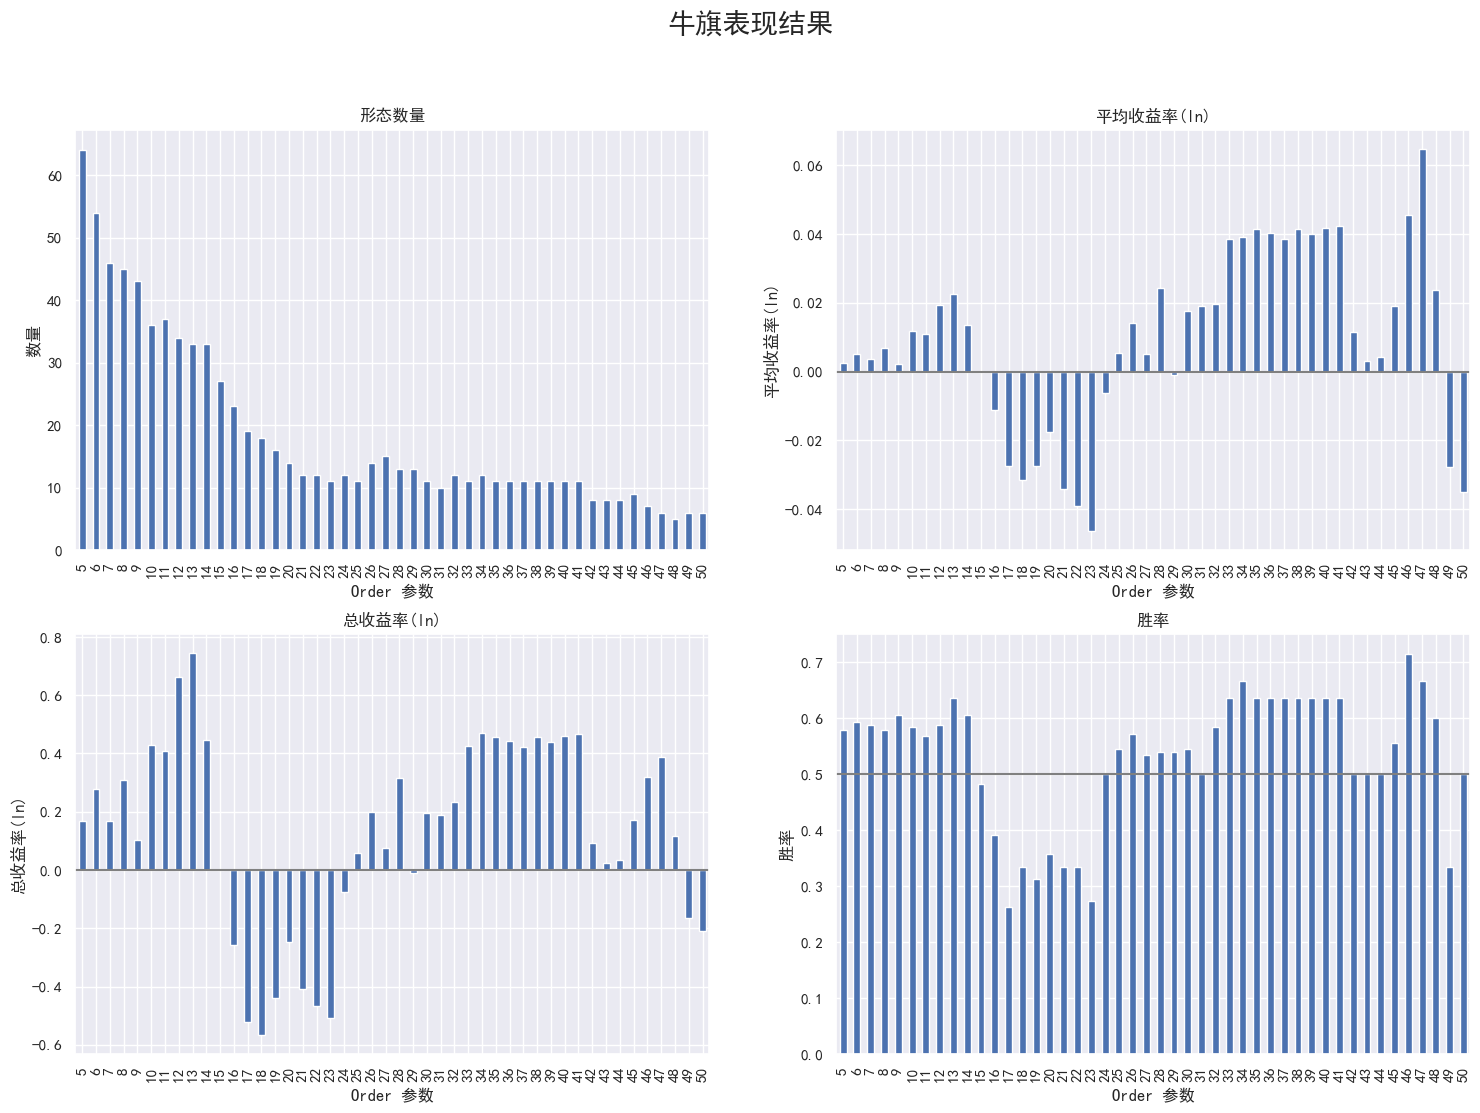

In [ ]:
import seaborn as sns
# 设置样式
sns.set_theme(style="darkgrid")
# sns.set_theme() 函数可以接受以下参数：
# context：控制绘图元素的比例，可选值有 "paper"、"notebook"、"talk"、"poster"，默认为 "notebook"
# style：控制绘图美学风格，可选值有 "darkgrid"、"whitegrid"、"dark"、"white"、"ticks"
# palette：控制颜色方案，可使用 Seaborn 内置调色板如 "deep"、"muted"、"bright" 等
# font：设置字体系列
# font_scale：字体大小的缩放因子
# color_codes：是否启用简短颜色代码
# rc：可传递字典覆盖默认的 matplotlib 参数

# sns.set_theme()与plt.style.use的区别：
# 1. sns.set_theme()是seaborn的新API，设置默认主题，包括颜色、网格等
# 2. plt.style.use直接使用Matplotlib的样式表，'seaborn-v0_8-bright'是保留的旧版seaborn风格
# sns.set_style("whitegrid")  # 设置网格样式

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# plt.style.use('seaborn-v0_8-bright')  # 使用seaborn亮色主题
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12

fig.suptitle("牛旗表现结果", fontsize=20)  # 设置总标题

# 绘制牛市旗形的四个指标
results_df['bull_flag_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bull_flag_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bull_flag_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bull_flag_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表

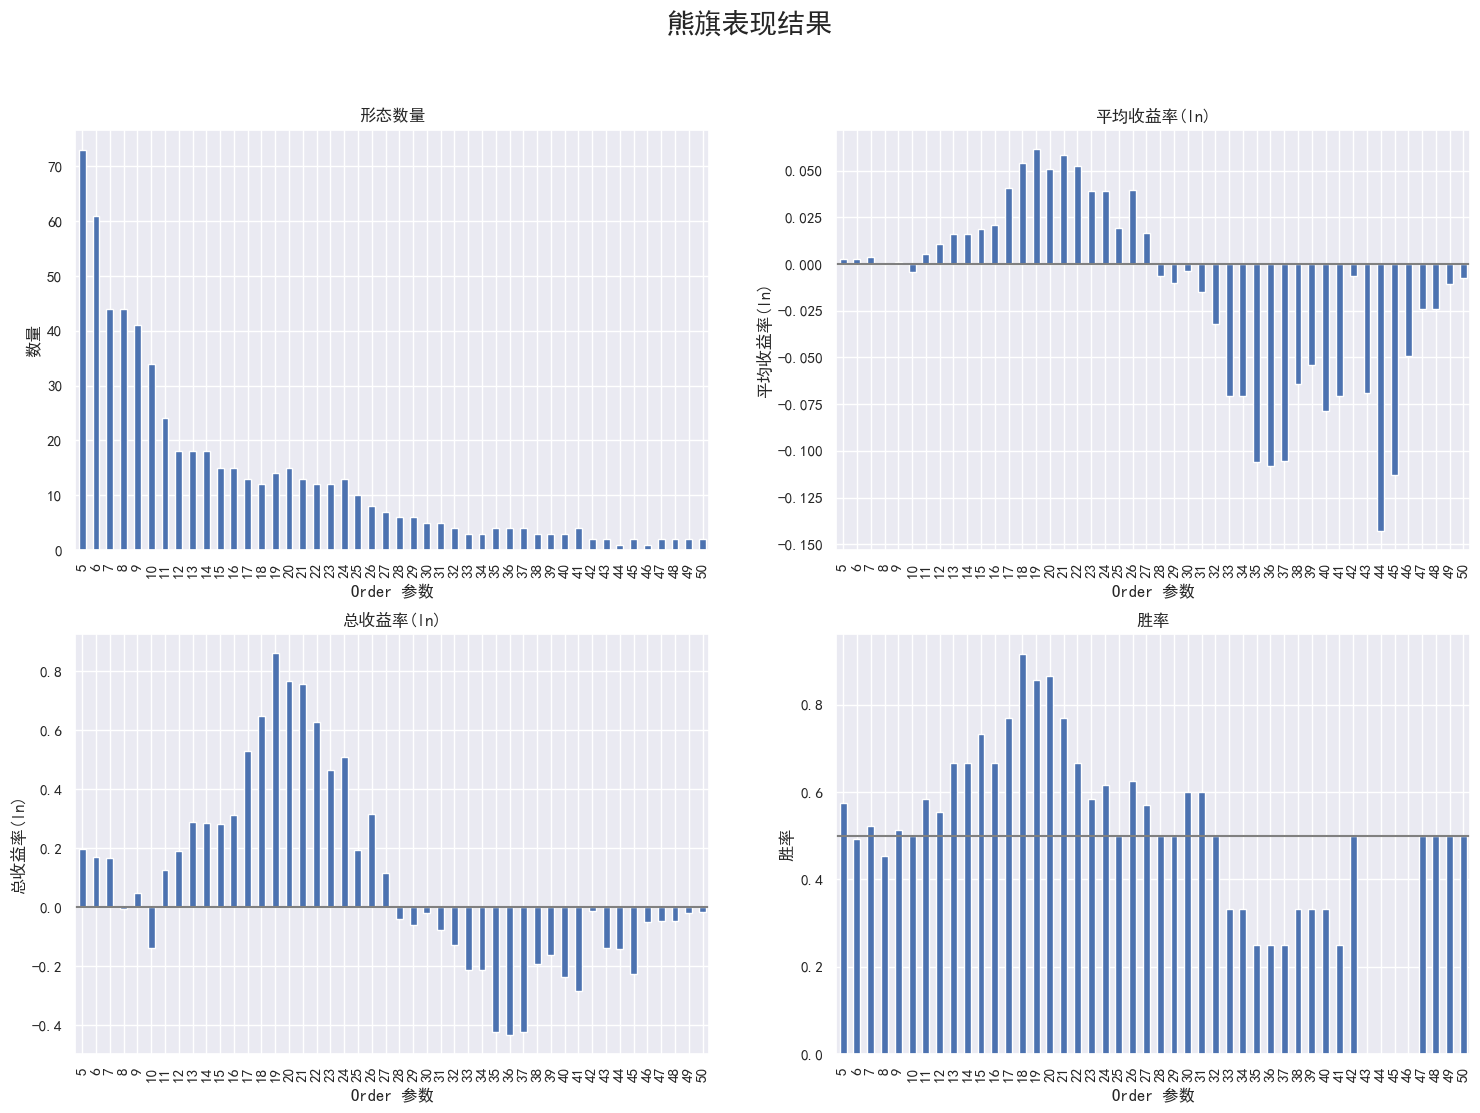

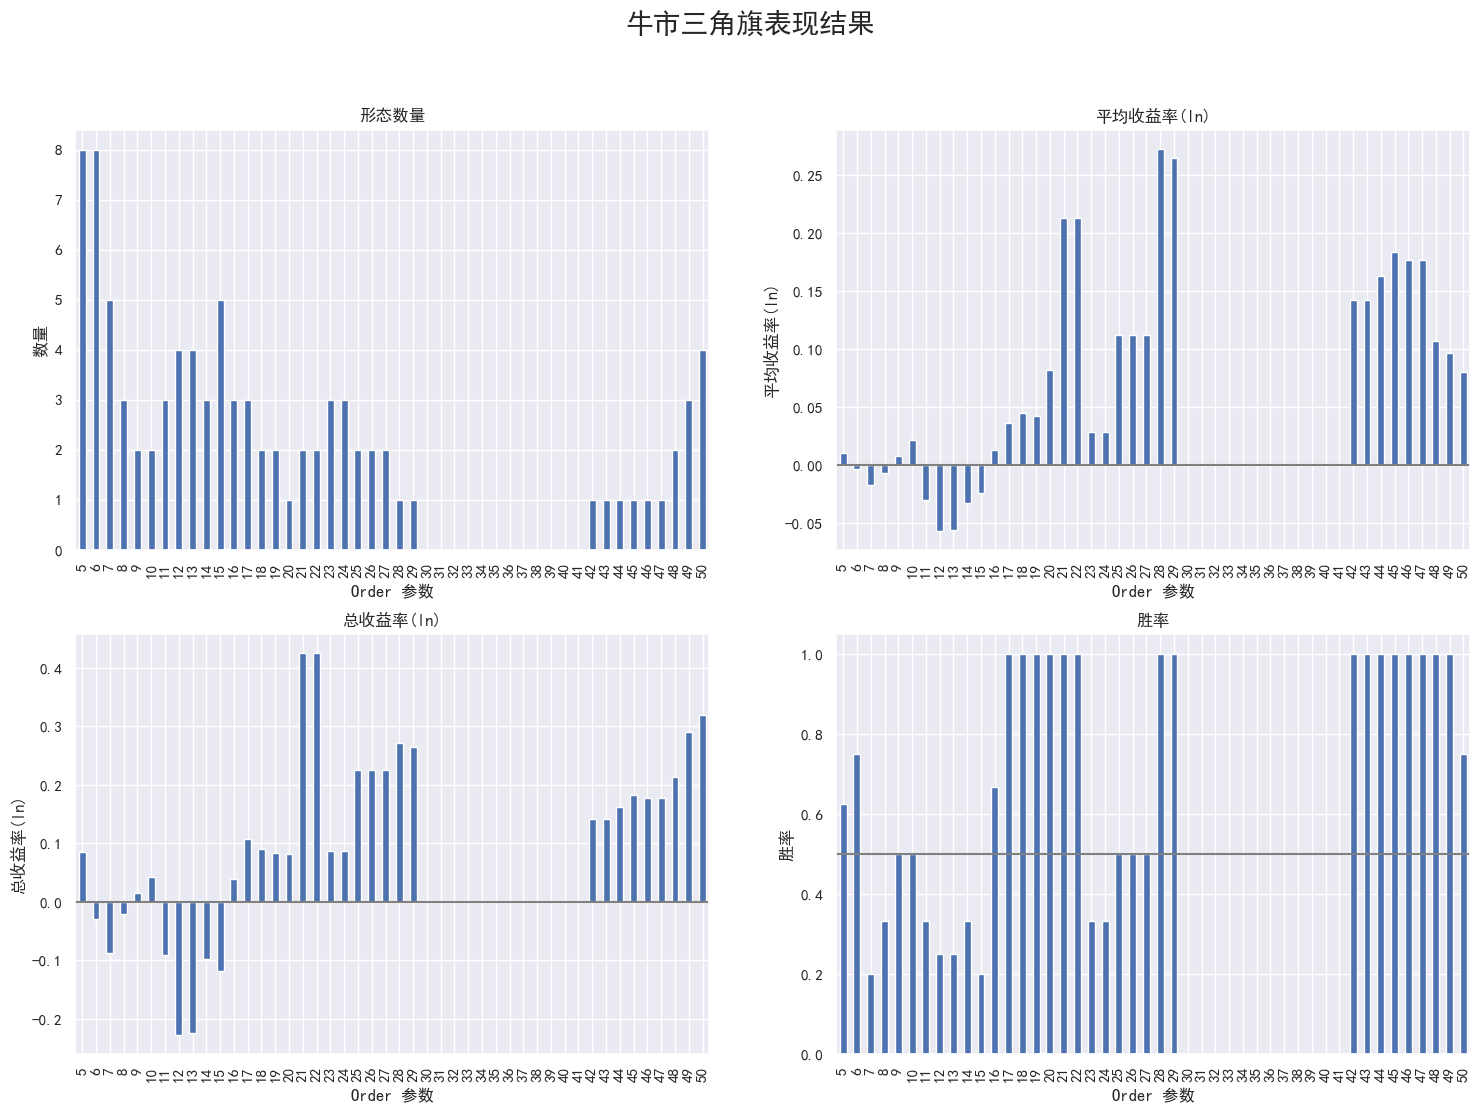

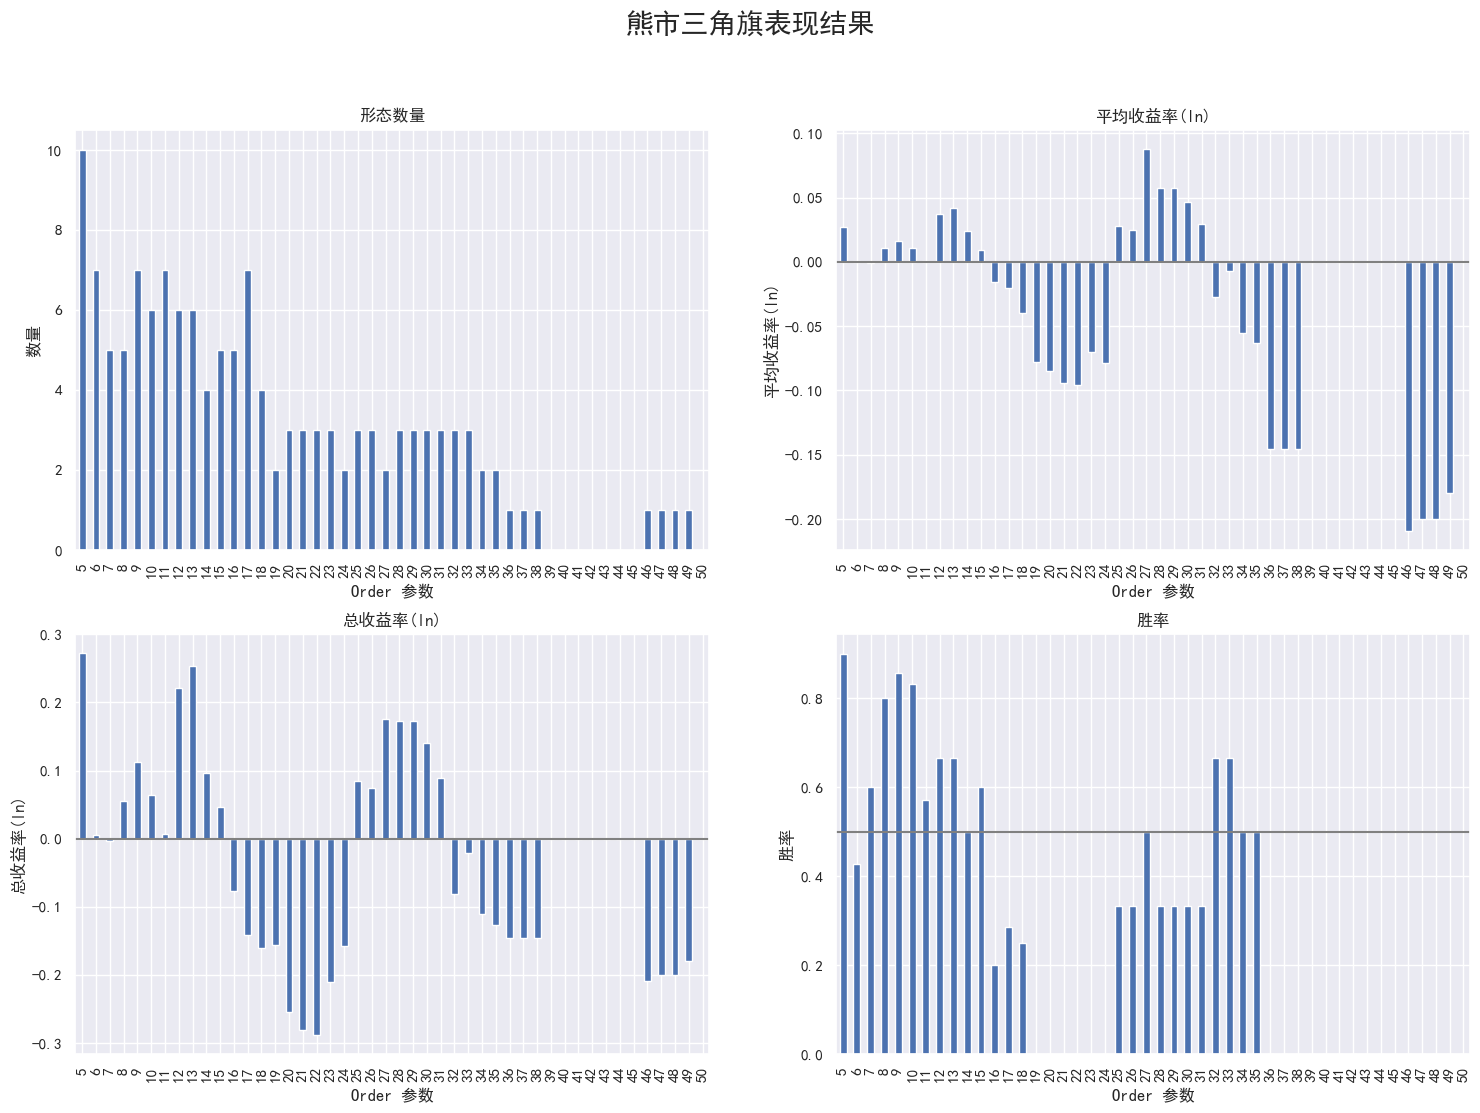

In [22]:
# 绘制熊市旗形的性能图表
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12
fig.suptitle("熊旗表现结果", fontsize=20)  # 设置总标题

# 绘制熊市旗形的四个指标
results_df['bear_flag_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bear_flag_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bear_flag_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bear_flag_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表


# 绘制牛市三角旗的性能图表
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12
fig.suptitle("牛市三角旗表现结果", fontsize=20)  # 设置总标题

# 绘制牛市三角旗的四个指标
results_df['bull_pennant_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bull_pennant_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bull_pennant_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bull_pennant_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表

# 绘制熊市三角旗的性能图表
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12
fig.suptitle("熊市三角旗表现结果", fontsize=20)  # 设置总标题

# 绘制熊市三角旗的四个指标
results_df['bear_pennant_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bear_pennant_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bear_pennant_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bear_pennant_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表